# Combined EDA all data
`sivigila` + `medicos_IPS` + `nofetal` + `poblation`

In [1]:
# Import libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

pd.set_option("display.max_columns",999)
pd.set_option('display.max_rows', 20)
mpl.rc('figure', max_open_warning = 0)

# 1. Load and Transform Datasets

## 1.1. Read data

In [2]:
sivigila=pd.read_parquet('../parquet_datasets/sivigila_2017_2018_S.parquet')
sivigila

,DEPARTAMENTO,ENFERMEDAD,FECHA,EDAD,SEXO
0,NORTE SANTANDER,CHAGAS,2017-08-01,46,M
1,BOYACA,CHAGAS,2017-05-01,87,F
2,TOLIMA,CHAGAS,2017-09-01,58,F
3,SANTANDER,CHAGAS,2017-08-01,68,F
4,CUNDINAMARCA,CHAGAS,2017-10-01,70,F
...,...,...,...,...,...
141005,VALLE,ZIKA,2018-07-01,36,M
141006,VALLE,ZIKA,2018-09-01,51,M
141007,VALLE,ZIKA,2018-05-01,38,F
141008,VALLE,ZIKA,2019-03-01,47,M


In [3]:
# Group 'Enfermedad'
dict_enfermedad={'CHAGAS':'CHAGAS',
                 'CHIKUNGUNYA':'CHIKUNGUNYA',
                 'INFECCION RESPIRATORIA AGUDA GRAVE IRAG INUSITADA':'IRA',
                 'LEISHMANIASIS CUTANEA':'LEISHMANIASIS',
                 'LEISHMANIASIS MUCOSA':'LEISHMANIASIS',
                 'LEISHMANIASIS VISCERAL':'LEISHMANIASIS',
                 'MALARIA ASOCIADA (FORMAS MIXTAS)':'MALARIA',
                 'MALARIA COMPLICADA':'MALARIA',
                 'MALARIA FALCIPARUM':'MALARIA',
                 'MALARIA VIVAX':'MALARIA',
                 'ZIKA':'ZIKA'}
sivigila=sivigila.assign(ENFERMEDAD = lambda x: x.ENFERMEDAD.map(dict_enfermedad))

In [4]:
medicos_ips=pd.read_parquet('../parquet_datasets/medicos_ips_S.parquet')
medicos_ips.columns=['DEPARTAMENTO','FECHA_APERTURA','CODIGO','TIPO']
medicos_ips

,DEPARTAMENTO,FECHA_APERTURA,CODIGO,TIPO
259039,Valle del cauca,2002-03-01,7600100828,Profesional Independiente
200641,Meta,2002-12-01,5057300003,Instituciones - IPS
200643,Meta,2002-12-01,5057300003,Instituciones - IPS
56015,Bogotá D.C,2002-12-01,1100100021,Profesional Independiente
200634,Meta,2002-12-01,5057300003,Instituciones - IPS
...,...,...,...,...
188268,Magdalena,2020-11-01,4700100508,Instituciones - IPS
187124,Magdalena,2020-11-01,4700100071,Instituciones - IPS
187121,Magdalena,2020-11-01,4700100071,Instituciones - IPS
143248,Cesar,2020-11-01,2000102062,Instituciones - IPS


In [5]:
nofetal=pd.read_parquet('../parquet_datasets/Nofetal_S.parquet')
nofetal.columns=['FECHA','DEPARTAMENTO','SEXO','GRUPO_EDAD','CAUSA']
nofetal=nofetal[['DEPARTAMENTO','CAUSA','FECHA','GRUPO_EDAD','SEXO']]
nofetal=nofetal[(nofetal.CAUSA== 'Ciertas enfermedades transmitidas por vectores y rabia') | (nofetal.CAUSA== 'IRA')]
nofetal

,DEPARTAMENTO,CAUSA,FECHA,GRUPO_EDAD,SEXO
295,Casanare,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 70 a 74 años,Femenino
829,Valle del Cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 80 a 84 años,Femenino
1113,Boyaca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 60 a 64 años,Masculino
1961,Valle del Cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 45 a 49 años,Masculino
2406,Caqueta,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 40 a 44 años,Femenino
...,...,...,...,...,...
462962,Sucre,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Masculino
463521,Norte de Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 60 a 64 años,Masculino
464086,Cesar,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Femenino
464113,Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 70 a 74 años,Masculino


In [6]:
poblacion=pd.read_parquet('../parquet_datasets/Poblacion2017_2018.parquet')
poblacion

,DEPARTAMENTO,AÑO,RANGOEDAD,SEXO,POBLACION
0,Norte de Santander,2017,De 100 años y más,Femenino,498
1,Cordoba,2017,De 100 años y más,Femenino,880
2,Risaralda,2017,De 100 años y más,Masculino,360
3,Cordoba,2017,De 100 años y más,Masculino,634
4,Risaralda,2017,De 100 años y más,Femenino,565
...,...,...,...,...,...
1381,Vichada,2018,De 75 a 79 años,Femenino,452
1382,Vichada,2018,De 80 a 84 años,Femenino,264
1383,Vichada,2018,De 85 a 89 años,Femenino,138
1384,Vichada,2018,De 90 a 94 años,Femenino,64


## 1.2. Unify values of the departments

In [7]:
dep_sivigila=sorted(list(sivigila.DEPARTAMENTO.unique()))
print(dep_sivigila)

['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAINIA', 'GUAJIRA', 'GUAVIARE', 'HUILA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE', 'VAUPES', 'VICHADA']


In [8]:
dep_med_ips=sorted(list(medicos_ips.DEPARTAMENTO.unique()))
print(dep_med_ips)

['Amazonas', 'Antioquia', 'Arauca', 'Atlántico', 'Bogotá D.C', 'Bolívar', 'Boyacá', 'Caldas', 'Caquetá', 'Casanare', 'Cauca', 'Cesar', 'Chocó', 'Cundinamarca', 'Córdoba', 'Guainía', 'Guaviare', 'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Putumayo', 'Quindío', 'Risaralda', 'San Andrés y Providencia', 'Santander', 'Sucre', 'Tolima', 'Valle del cauca', 'Vaupés', 'Vichada']


In [9]:
dep_nofetal=sorted(list(nofetal.DEPARTAMENTO.unique()))
print(dep_nofetal)

['Amazonas', 'Antioquia', 'Arauca', 'Atlántico', 'Bogotá', 'Bolivar', 'Boyaca', 'Caldas', 'Caqueta', 'Casanare', 'Cauca', 'Cesar', 'Choco', 'Cordoba', 'Cundinamarca', 'Guainía', 'Guaviare', 'Huila', 'La guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Putumayo', 'Quindio', 'Risaralda', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca', 'Vaupés', 'Vichada']


In [10]:
dep_poblacion=sorted(list(poblacion.DEPARTAMENTO.unique()))
print(dep_poblacion)

['Amazonas', 'Antioquia', 'Arauca', 'Atlántico', 'Bogotá', 'Bolivar', 'Boyaca', 'Caldas', 'Caqueta', 'Casanare', 'Cauca', 'Cesar', 'Choco', 'Cordoba', 'Cundinamarca', 'Guainía', 'Guaviare', 'Huila', 'La guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Putumayo', 'Quindio', 'Risaralda', 'San Andrés y Providencia', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca', 'Vaupés', 'Vichada']


Define function that returns the closest string

In [11]:
from fuzzywuzzy import process
def dep_finder(DEPARTAMENTO, data_list):
    closest_match = process.extractOne(DEPARTAMENTO,data_list)
    return closest_match[0]

Create dictinary to match values of `dep_sivigila` with `dep_med_ips`

In [12]:
dep_dic1=defaultdict(str)
for i in dep_sivigila:
    j=dep_finder(i,dep_med_ips)
    dep_dic1[i]=j
dep_dic1

defaultdict(str,
            {'AMAZONAS': 'Amazonas',
             'ANTIOQUIA': 'Antioquia',
             'ARAUCA': 'Arauca',
             'ATLANTICO': 'Atlántico',
             'BOGOTA': 'Bogotá D.C',
             'BOLIVAR': 'Bolívar',
             'BOYACA': 'Boyacá',
             'CALDAS': 'Caldas',
             'CAQUETA': 'Caquetá',
             'CASANARE': 'Casanare',
             'CAUCA': 'Cauca',
             'CESAR': 'Cesar',
             'CHOCO': 'Chocó',
             'CORDOBA': 'Córdoba',
             'CUNDINAMARCA': 'Cundinamarca',
             'GUAINIA': 'Guainía',
             'GUAJIRA': 'La Guajira',
             'GUAVIARE': 'Guaviare',
             'HUILA': 'Huila',
             'MAGDALENA': 'Magdalena',
             'META': 'Meta',
             'NARIÑO': 'Nariño',
             'NORTE SANTANDER': 'Norte de Santander',
             'PUTUMAYO': 'Putumayo',
             'QUINDIO': 'Quindío',
             'RISARALDA': 'Risaralda',
             'SAN ANDRES': 'San Andrés y Prov

Create dictinary to match values of `dep_nofetal` with `dep_med_ips`

In [13]:
dep_dic2=defaultdict(str)
for i in dep_nofetal:
    j=dep_finder(i,dep_med_ips)
    dep_dic2[i]=j
dep_dic2

defaultdict(str,
            {'Amazonas': 'Amazonas',
             'Antioquia': 'Antioquia',
             'Arauca': 'Arauca',
             'Atlántico': 'Atlántico',
             'Bogotá': 'Bogotá D.C',
             'Bolivar': 'Bolívar',
             'Boyaca': 'Boyacá',
             'Caldas': 'Caldas',
             'Caqueta': 'Caquetá',
             'Casanare': 'Casanare',
             'Cauca': 'Cauca',
             'Cesar': 'Cesar',
             'Choco': 'Chocó',
             'Cordoba': 'Córdoba',
             'Cundinamarca': 'Cundinamarca',
             'Guainía': 'Guainía',
             'Guaviare': 'Guaviare',
             'Huila': 'Huila',
             'La guajira': 'La Guajira',
             'Magdalena': 'Magdalena',
             'Meta': 'Meta',
             'Nariño': 'Nariño',
             'Norte de Santander': 'Norte de Santander',
             'Putumayo': 'Putumayo',
             'Quindio': 'Quindío',
             'Risaralda': 'Risaralda',
             'Santander': 'Santander',


Create dictinary to match values of `dep_poblacion` with `dep_med_ips`

In [14]:
dep_dic3=defaultdict(str)
for i in dep_poblacion:
    j=dep_finder(i,dep_med_ips)
    dep_dic3[i]=j
dep_dic3

defaultdict(str,
            {'Amazonas': 'Amazonas',
             'Antioquia': 'Antioquia',
             'Arauca': 'Arauca',
             'Atlántico': 'Atlántico',
             'Bogotá': 'Bogotá D.C',
             'Bolivar': 'Bolívar',
             'Boyaca': 'Boyacá',
             'Caldas': 'Caldas',
             'Caqueta': 'Caquetá',
             'Casanare': 'Casanare',
             'Cauca': 'Cauca',
             'Cesar': 'Cesar',
             'Choco': 'Chocó',
             'Cordoba': 'Córdoba',
             'Cundinamarca': 'Cundinamarca',
             'Guainía': 'Guainía',
             'Guaviare': 'Guaviare',
             'Huila': 'Huila',
             'La guajira': 'La Guajira',
             'Magdalena': 'Magdalena',
             'Meta': 'Meta',
             'Nariño': 'Nariño',
             'Norte de Santander': 'Norte de Santander',
             'Putumayo': 'Putumayo',
             'Quindio': 'Quindío',
             'Risaralda': 'Risaralda',
             'San Andrés y Providencia'

Apply the dictionary to the datasets and replace `DEPARTAMENTO` with the new values.

In [15]:
sivigila['DEPARTAMENTO'] = sivigila.apply(lambda x: dep_dic1[x['DEPARTAMENTO']],axis=1)
sivigila.DEPARTAMENTO=sivigila.DEPARTAMENTO.astype('category')

nofetal['DEPARTAMENTO'] = nofetal.apply(lambda x: dep_dic2[x['DEPARTAMENTO']],axis=1)
nofetal.DEPARTAMENTO=nofetal.DEPARTAMENTO.astype('category')

poblacion['DEPARTAMENTO'] = poblacion.apply(lambda x: dep_dic3[x['DEPARTAMENTO']],axis=1)
poblacion.DEPARTAMENTO=poblacion.DEPARTAMENTO.astype('category')

## 1.2. JOIN DATA

* All by year

In [16]:
poblacion_agg_año=poblacion.groupby(['DEPARTAMENTO','AÑO']).agg(TOTAL_POBLACION=('POBLACION','sum')).reset_index()
poblacion_agg_año

,DEPARTAMENTO,AÑO,TOTAL_POBLACION
0,Amazonas,2017,148052
1,Amazonas,2018,153178
2,Antioquia,2017,12593102
3,Antioquia,2018,12814204
4,Arauca,2017,509643
...,...,...,...
61,Valle del cauca,2018,8951772
62,Vaupés,2017,78505
63,Vaupés,2018,81594
64,Vichada,2017,209068


In [17]:
sivigila['AÑO']=sivigila.FECHA.dt.year
sivigila=sivigila.query('AÑO==2017 or AÑO==2018')

In [18]:
sivigila_agg_año=sivigila.groupby(['DEPARTAMENTO','AÑO']).agg(TOTAL_ENFERMEDADES=('ENFERMEDAD','count')).reset_index()
sivigila_agg_año

,DEPARTAMENTO,AÑO,TOTAL_ENFERMEDADES
0,Amazonas,2017,2569
1,Amazonas,2018,2312
2,Antioquia,2017,6271
3,Antioquia,2018,6917
4,Arauca,2017,125
...,...,...,...
61,Valle del cauca,2018,1716
62,Vaupés,2017,487
63,Vaupés,2018,659
64,Vichada,2017,2047


In [19]:
medicos_ips['AÑO']= medicos_ips.FECHA_APERTURA.dt.year

In [20]:
medicos_ips_agg_año=medicos_ips.groupby(['DEPARTAMENTO','TIPO','AÑO'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0,1]).cumsum().reset_index()
medicos_ips_agg_año

,DEPARTAMENTO,TIPO,AÑO,TOTAL_ACUMULADO
0,Amazonas,Instituciones - IPS,2002,0
1,Amazonas,Instituciones - IPS,2003,6
2,Amazonas,Instituciones - IPS,2004,6
3,Amazonas,Instituciones - IPS,2005,6
4,Amazonas,Instituciones - IPS,2006,6
...,...,...,...,...
1249,Vichada,Profesional Independiente,2016,0
1250,Vichada,Profesional Independiente,2017,2
1251,Vichada,Profesional Independiente,2018,2
1252,Vichada,Profesional Independiente,2019,2


In [21]:
ips_agg_año=medicos_ips_agg_año[medicos_ips_agg_año.TIPO=='Instituciones - IPS']
medicos_agg_año=medicos_ips_agg_año[medicos_ips_agg_año.TIPO=='Profesional Independiente']

ips_agg_año=ips_agg_año.rename(columns={"TOTAL_ACUMULADO": "TOTAL_IPS"}).drop(columns='TIPO')
medicos_agg_año=medicos_agg_año.rename(columns={"TOTAL_ACUMULADO": "TOTAL_MED"}).drop(columns='TIPO')

In [22]:
medicos_ips_agg_año=pd.merge(medicos_agg_año,ips_agg_año, on=['DEPARTAMENTO','AÑO'])
medicos_ips_agg_año

,DEPARTAMENTO,AÑO,TOTAL_MED,TOTAL_IPS
0,Amazonas,2002,0,0
1,Amazonas,2003,3,6
2,Amazonas,2004,3,6
3,Amazonas,2005,3,6
4,Amazonas,2006,3,6
...,...,...,...,...
622,Vichada,2016,0,48
623,Vichada,2017,2,56
624,Vichada,2018,2,64
625,Vichada,2019,2,70


In [23]:
nofetal

,DEPARTAMENTO,CAUSA,FECHA,GRUPO_EDAD,SEXO
295,Casanare,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 70 a 74 años,Femenino
829,Valle del cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 80 a 84 años,Femenino
1113,Boyacá,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 60 a 64 años,Masculino
1961,Valle del cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 45 a 49 años,Masculino
2406,Caquetá,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 40 a 44 años,Femenino
...,...,...,...,...,...
462962,Sucre,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Masculino
463521,Norte de Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 60 a 64 años,Masculino
464086,Cesar,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Femenino
464113,Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 70 a 74 años,Masculino


In [24]:
nofetal['AÑO']= nofetal.FECHA.dt.year

In [25]:
nofetals_agg_año=nofetal.groupby(['DEPARTAMENTO','CAUSA','AÑO'])\
    .agg(TOTAL_MUERTES=('CAUSA','count')).reset_index()
nofetals_agg_año

,DEPARTAMENTO,CAUSA,AÑO,TOTAL_MUERTES
0,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017,3
1,Amazonas,Ciertas enfermedades transmitidas por vectores...,2018,0
2,Amazonas,IRA,2017,0
3,Amazonas,IRA,2018,3
4,Antioquia,Ciertas enfermedades transmitidas por vectores...,2017,5
...,...,...,...,...
123,Vaupés,IRA,2018,3
124,Vichada,Ciertas enfermedades transmitidas por vectores...,2017,3
125,Vichada,Ciertas enfermedades transmitidas por vectores...,2018,0
126,Vichada,IRA,2017,0


In [26]:
vectores_agg=nofetals_agg_año[nofetals_agg_año.CAUSA=='Ciertas enfermedades transmitidas por vectores y rabia']
ira_agg=nofetals_agg_año[nofetals_agg_año.CAUSA=='IRA']

vectores_agg=vectores_agg.rename(columns={"TOTAL_MUERTES": "TOTAL_MUERTES_VECTORES"}).drop(columns='CAUSA')
ira_agg=ira_agg.rename(columns={"TOTAL_MUERTES": "TOTAL_MUERTES_IRA"}).drop(columns='CAUSA')

In [27]:
nofetals_agg_año=pd.merge(vectores_agg,ira_agg, on=['DEPARTAMENTO','AÑO'])
nofetals_agg_año

,DEPARTAMENTO,AÑO,TOTAL_MUERTES_VECTORES,TOTAL_MUERTES_IRA
0,Amazonas,2017,3,0
1,Amazonas,2018,0,3
2,Antioquia,2017,5,0
3,Antioquia,2018,9,65
4,Arauca,2017,11,0
...,...,...,...,...
59,Valle del cauca,2018,9,30
60,Vaupés,2017,0,0
61,Vaupés,2018,0,3
62,Vichada,2017,3,0


In [28]:
m1=pd.merge(medicos_ips_agg_año,sivigila_agg_año, on=['DEPARTAMENTO','AÑO'])
m2=pd.merge(m1,nofetals_agg_año, on=['DEPARTAMENTO','AÑO'])
data_merge=pd.merge(m2,poblacion_agg_año, on=['DEPARTAMENTO','AÑO'])
data_merge

,DEPARTAMENTO,AÑO,TOTAL_MED,TOTAL_IPS,TOTAL_ENFERMEDADES,TOTAL_MUERTES_VECTORES,TOTAL_MUERTES_IRA,TOTAL_POBLACION
0,Amazonas,2017,6,110,2569,3,0,148052
1,Amazonas,2018,6,115,2312,0,3,153178
2,Antioquia,2017,1328,3098,6271,5,0,12593102
3,Antioquia,2018,1674,3431,6917,9,65,12814204
4,Arauca,2017,30,257,125,11,0,509643
...,...,...,...,...,...,...,...,...
59,Valle del cauca,2018,907,3231,1716,9,30,8951772
60,Vaupés,2017,0,28,487,0,0,78505
61,Vaupés,2018,0,30,659,0,3,81594
62,Vichada,2017,2,56,2047,3,0,209068


* Illness by moth and repeat data in ips

In [29]:
sivigila_b=sivigila.assign(PERIODO = sivigila.FECHA.dt.to_period('M'))

In [30]:
sivigilas_agg=sivigila_b.groupby(['DEPARTAMENTO','ENFERMEDAD','PERIODO'])\
    .agg(TOTAL_MES=('ENFERMEDAD','count')).reset_index()
sivigilas_agg=sivigilas_agg.assign(AÑO = lambda x: x.PERIODO.astype('str').str[0:4])

In [31]:
sivigilas_agg=sivigilas_agg[sivigilas_agg.AÑO.isin(['2017','2018'])]

In [32]:
sivigilas_agg.AÑO=sivigilas_agg.AÑO.astype('int64')

In [33]:
m1=pd.merge(sivigilas_agg,ips_agg_año,on=['DEPARTAMENTO','AÑO'], how='left')
ENFERMEDAD_IPS=pd.merge(m1,poblacion_agg_año, on=['DEPARTAMENTO','AÑO'], how='left')

In [34]:
ENFERMEDAD_IPS=ENFERMEDAD_IPS.assign(IPS_1M_P_AÑO = lambda x: (x.TOTAL_IPS*1000000)/(x.TOTAL_POBLACION))

In [35]:
ENFERMEDAD_IPS.PERIODO=ENFERMEDAD_IPS.PERIODO.astype('str')

In [36]:
ENFERMEDAD_IPS

,DEPARTAMENTO,ENFERMEDAD,PERIODO,TOTAL_MES,AÑO,TOTAL_IPS,TOTAL_POBLACION,IPS_1M_P_AÑO
0,Amazonas,CHAGAS,2017-01,0,2017,110,148052,742.982195
1,Amazonas,CHAGAS,2017-02,0,2017,110,148052,742.982195
2,Amazonas,CHAGAS,2017-03,0,2017,110,148052,742.982195
3,Amazonas,CHAGAS,2017-04,0,2017,110,148052,742.982195
4,Amazonas,CHAGAS,2017-05,0,2017,110,148052,742.982195
...,...,...,...,...,...,...,...,...
4747,Vichada,ZIKA,2018-08,0,2018,64,215616,296.823983
4748,Vichada,ZIKA,2018-09,0,2018,64,215616,296.823983
4749,Vichada,ZIKA,2018-10,1,2018,64,215616,296.823983
4750,Vichada,ZIKA,2018-11,0,2018,64,215616,296.823983


In [37]:
ENFERMEDAD_IPS.PERIODO=ENFERMEDAD_IPS.PERIODO.astype('str')

In [38]:
sivigila.to_parquet('../parquet_datasets/sivigila_D.parquet')
medicos_ips.to_parquet('../parquet_datasets/medicos_ips_D.parquet')
nofetal.to_parquet('../parquet_datasets/nofetal_D.parquet')
poblacion.to_parquet('../parquet_datasets/poblacion_D.parquet')
data_merge.to_parquet('../parquet_datasets/data_merge.parquet')
ENFERMEDAD_IPS.to_parquet('../parquet_datasets/ENFERMEDAD_IPS.parquet')

# 2. EDA `medicos_ips`

## 2.1. Trends over time by department

In [39]:
medicos_ips['AÑO']= medicos_ips.FECHA_APERTURA.dt.strftime('%Y')

In [40]:
medicos_ips_agg=medicos_ips.groupby(['DEPARTAMENTO','TIPO','AÑO'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0,1]).cumsum().reset_index()
medicos_ips_agg

,DEPARTAMENTO,TIPO,AÑO,TOTAL_ACUMULADO
0,Amazonas,Instituciones - IPS,2002,0
1,Amazonas,Instituciones - IPS,2003,6
2,Amazonas,Instituciones - IPS,2004,6
3,Amazonas,Instituciones - IPS,2005,6
4,Amazonas,Instituciones - IPS,2006,6
...,...,...,...,...
1249,Vichada,Profesional Independiente,2016,0
1250,Vichada,Profesional Independiente,2017,2
1251,Vichada,Profesional Independiente,2018,2
1252,Vichada,Profesional Independiente,2019,2


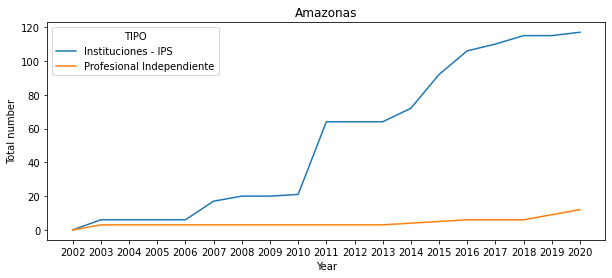

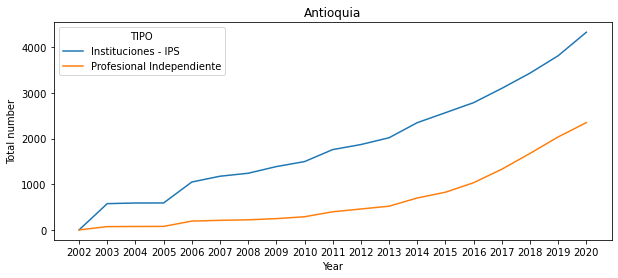

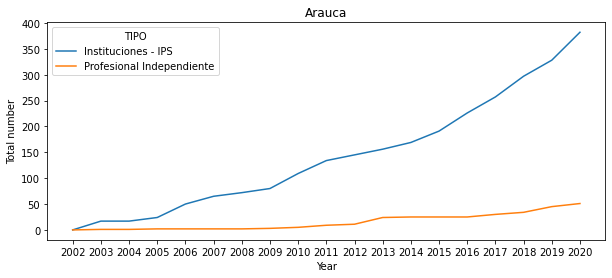

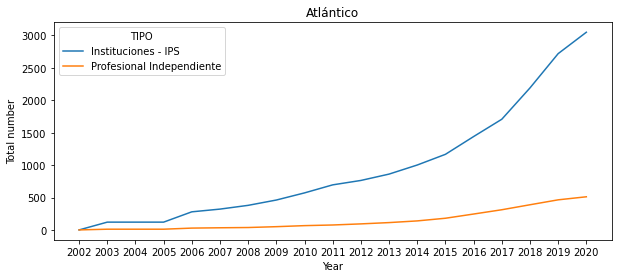

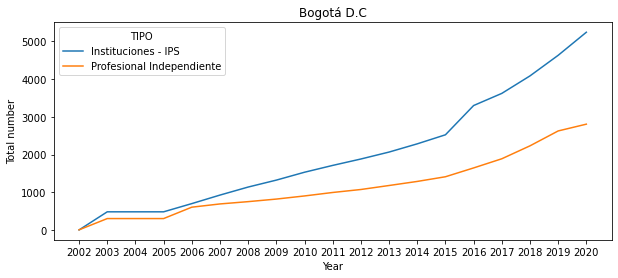

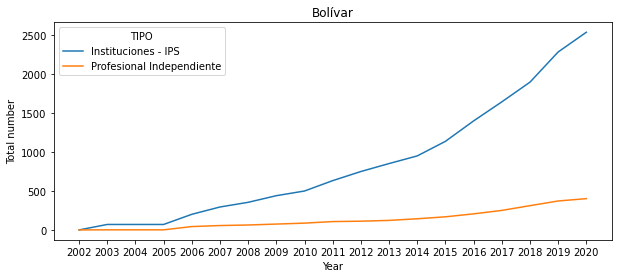

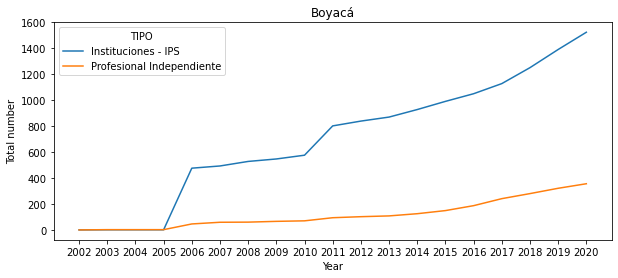

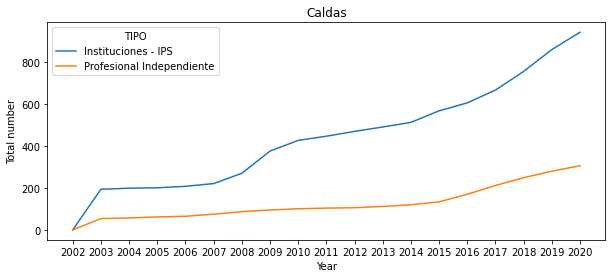

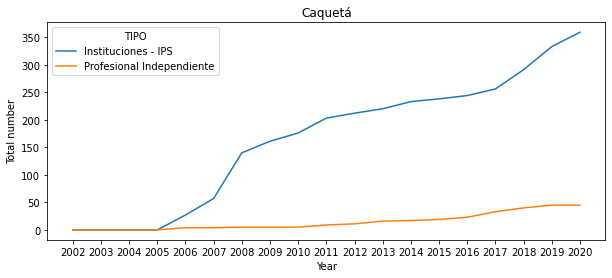

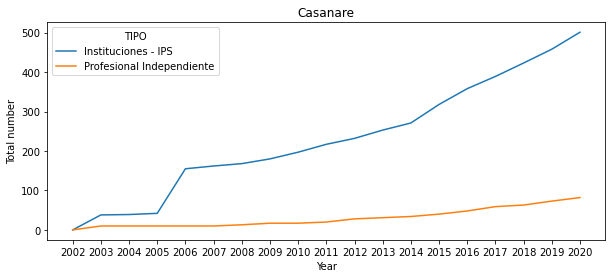

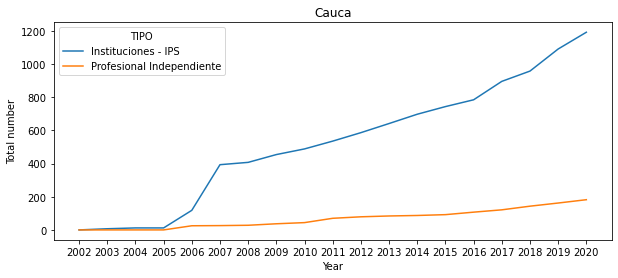

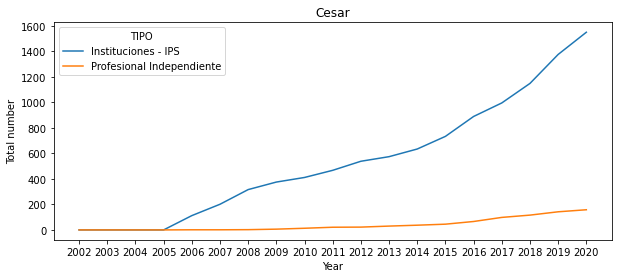

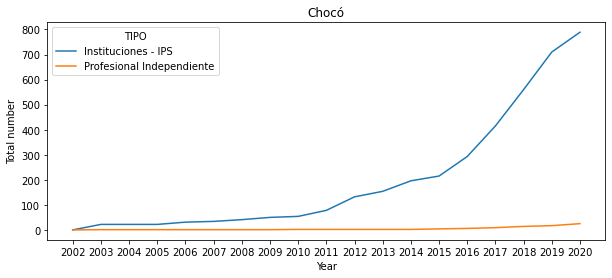

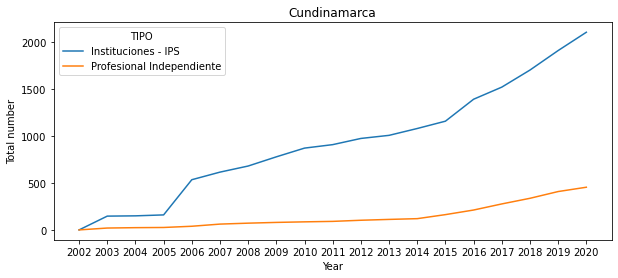

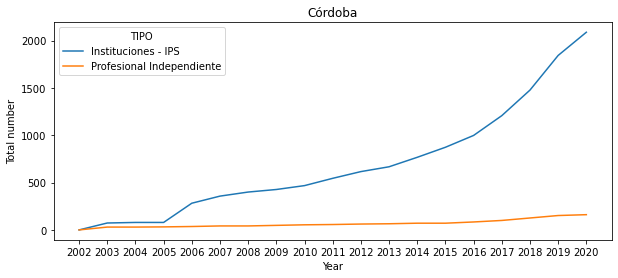

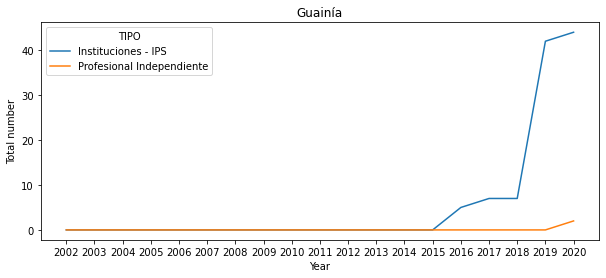

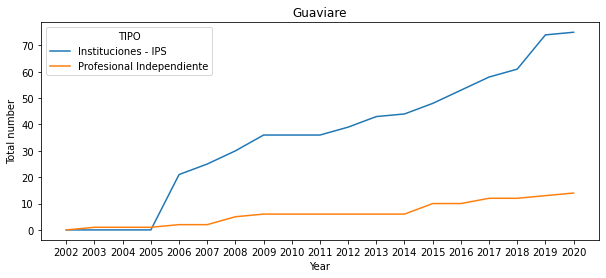

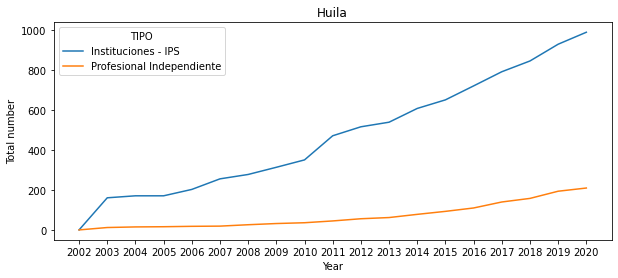

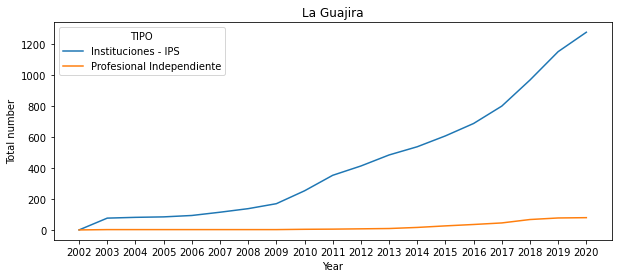

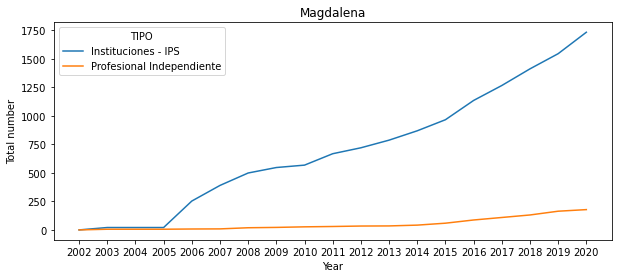

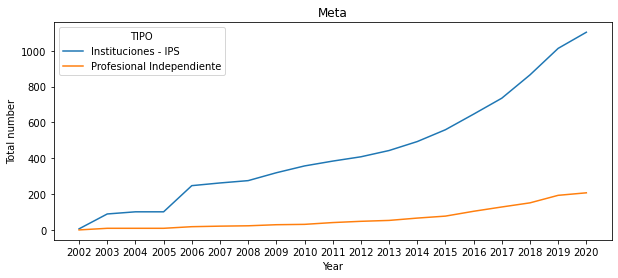

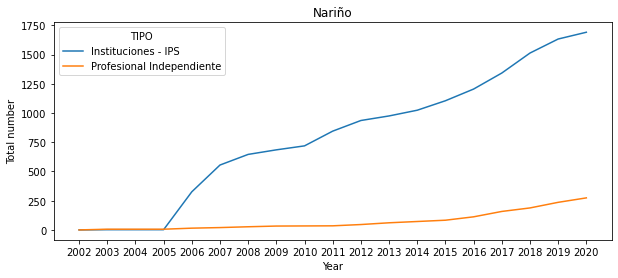

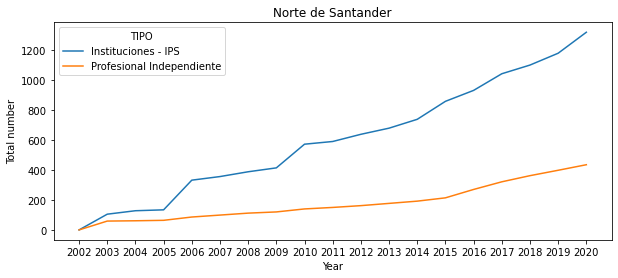

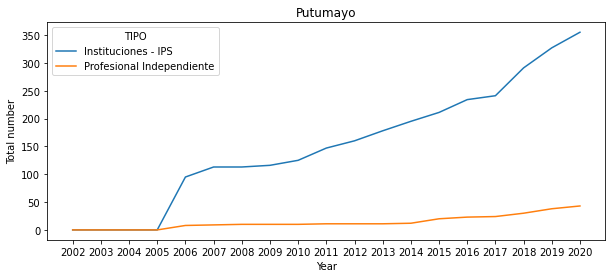

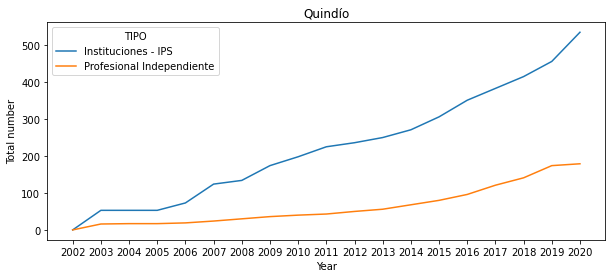

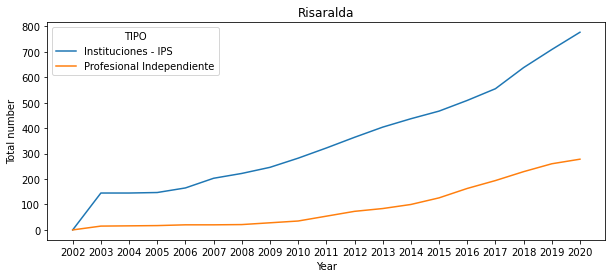

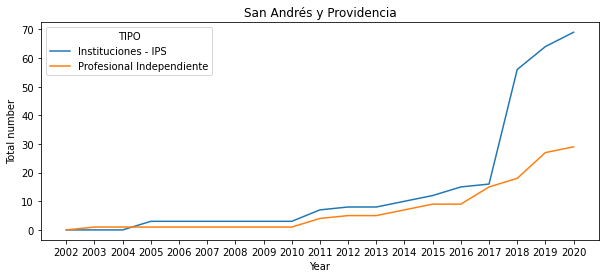

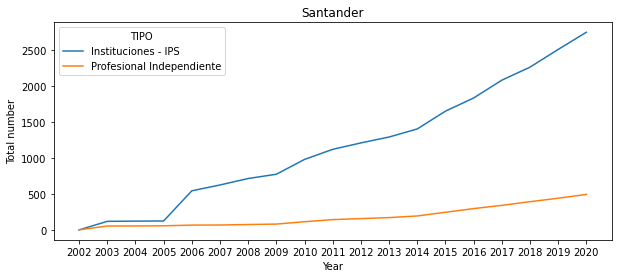

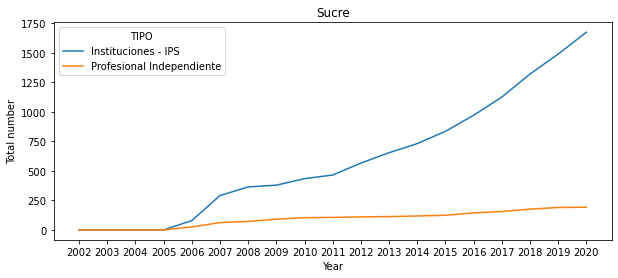

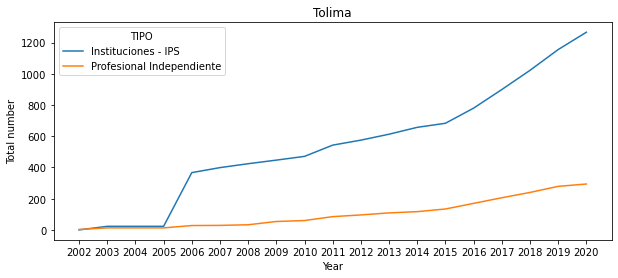

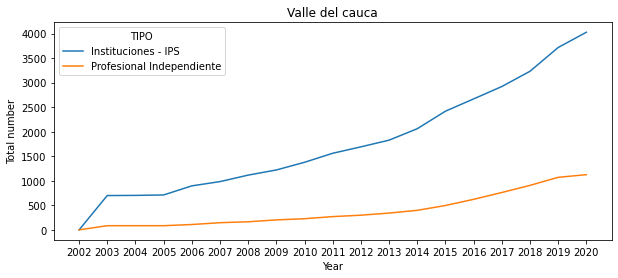

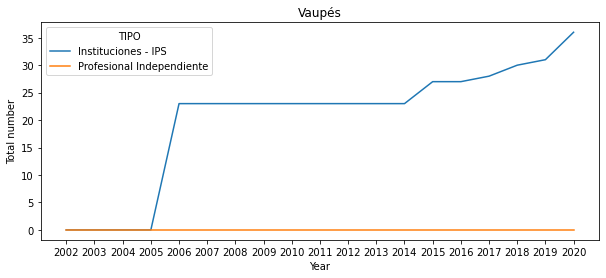

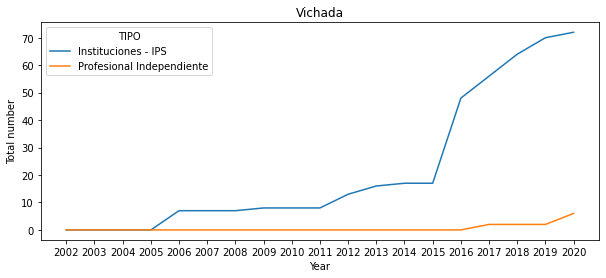

In [41]:
for i in medicos_ips_agg.DEPARTAMENTO.unique():
    fig= plt.figure(figsize=(10,4))
    sns.lineplot(data=medicos_ips_agg[medicos_ips_agg.DEPARTAMENTO==i]\
                 ,x='AÑO', y='TOTAL_ACUMULADO', hue='TIPO');
    plt.ylabel('Total number')
    plt.xlabel('Year')
    plt.title(i);

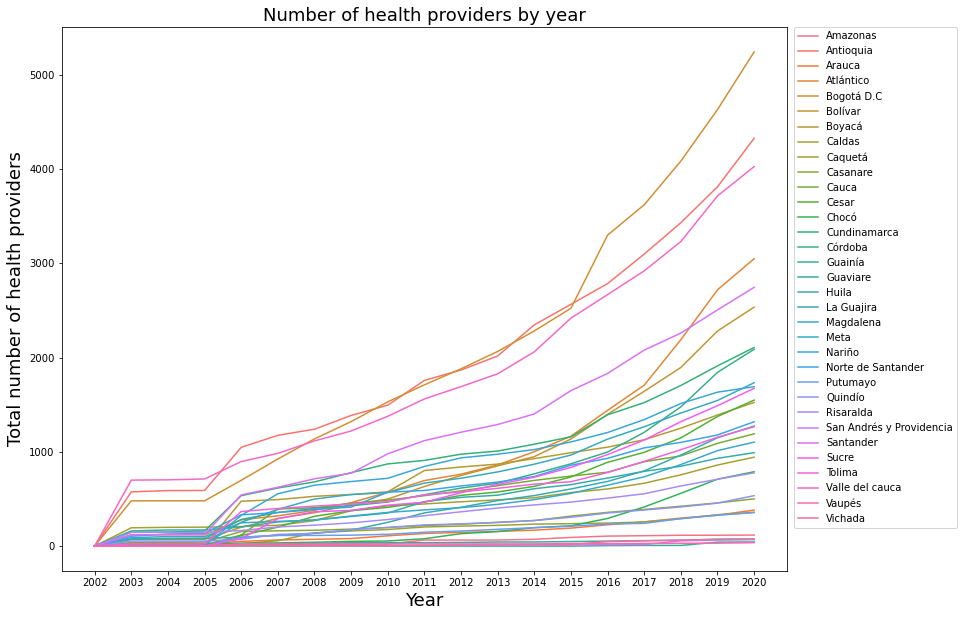

In [42]:
fig= plt.figure(figsize=(13,10))
sns.lineplot(data=medicos_ips_agg.query('TIPO=="Instituciones - IPS"')\
             ,x='AÑO', y='TOTAL_ACUMULADO', hue='DEPARTAMENTO');
plt.ylabel('Total number of health providers', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('Number of health providers by year', fontsize=18);
plt.savefig(f"../images/Number_of_health_providers_by_year.jpg", dpi=150,bbox_inches='tight', pad_inches=0.3) 

## 2.2. Trends over time total

In [43]:
medicos_ips_agg_2=medicos_ips.groupby(['TIPO','AÑO'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0]).cumsum().reset_index()
medicos_ips_agg_2

,TIPO,AÑO,TOTAL_ACUMULADO
0,Instituciones - IPS,2002,6
1,Instituciones - IPS,2003,3244
2,Instituciones - IPS,2004,3334
3,Instituciones - IPS,2005,3382
4,Instituciones - IPS,2006,7952
...,...,...,...
33,Profesional Independiente,2016,6314
34,Profesional Independiente,2017,7696
35,Profesional Independiente,2018,9215
36,Profesional Independiente,2019,10906


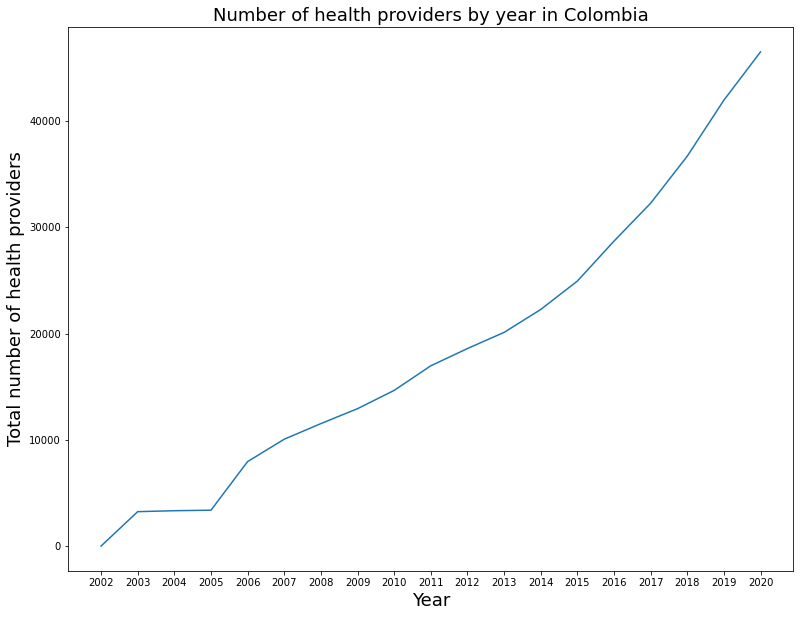

In [44]:
fig= plt.figure(figsize=(13,10))
sns.lineplot(data=medicos_ips_agg_2.query('TIPO=="Instituciones - IPS"')\
             ,x='AÑO', y='TOTAL_ACUMULADO');
plt.ylabel('Total number of health providers', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Number of health providers by year in Colombia', fontsize=18)
plt.savefig(f"../images/Number_of_health_providers_by_year_in_Colombia.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

## 2.3. Projection number of IPS

In [45]:
# Create projection years series
YEAR_TEST=pd.period_range(start='2020-11', periods=5, freq='Y').to_timestamp()
YEAR_TEST=pd.Series(YEAR_TEST).dt.strftime('%Y')
YEAR_TEST

0    2020
1    2021
2    2022
3    2023
4    2024
dtype: object

In [46]:
# Filter type 'Instituciones - IPS'
medicos_ips_agg_2_ips=medicos_ips_agg_2[medicos_ips_agg_2.TIPO== 'Instituciones - IPS']

In [47]:
# Split the data in x , y  for the models
x_train=np.array(medicos_ips_agg_2_ips['AÑO']).reshape(-1, 1)
y_train=np.array(medicos_ips_agg_2_ips['TOTAL_ACUMULADO']).reshape(-1, 1)

x_future=np.array(YEAR_TEST).reshape(-1, 1)

In [48]:
# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

LinearRegression()

In [49]:
# Predict and extrapolate
y_pred=lin_reg.predict(x_train)
y_future=lin_reg.predict(x_future)

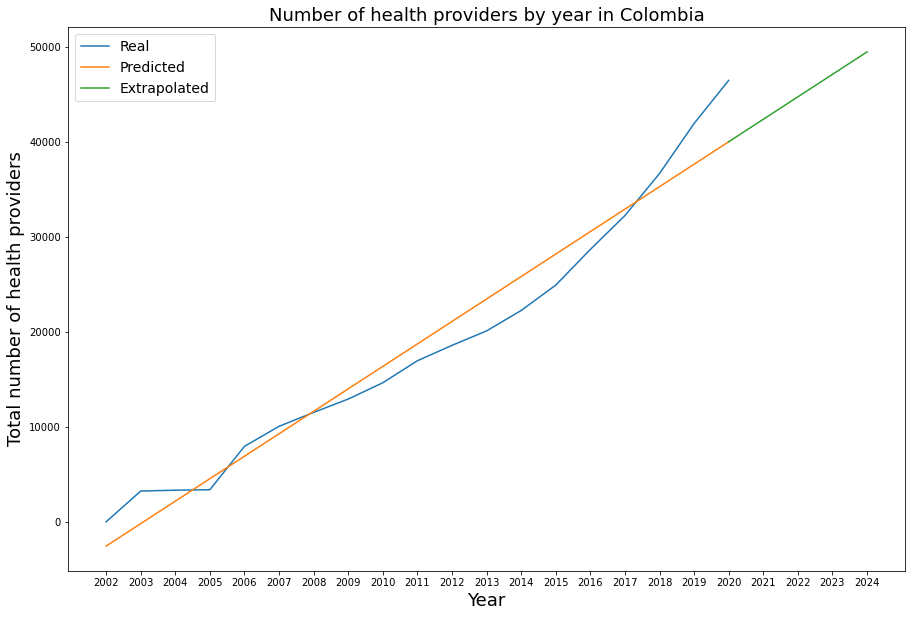

In [50]:
# Plot
fig= plt.figure(figsize=(15,10))
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_train.flatten())
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_pred.flatten())
sns.lineplot(x=YEAR_TEST, y=y_future.flatten())
plt.legend(('Real', 'Predicted', 'Extrapolated'),fontsize=14)
plt.ylabel('Total number of health providers', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Number of health providers by year in Colombia', fontsize=18)
plt.savefig(f"../images/Number_of_health_providers_by_year_in_Colombia_Linear_reg.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

In [51]:
# Train Polynomial Regression degree =3
poly_reg=make_pipeline(PolynomialFeatures(degree=3),LinearRegression())
poly_reg.fit(x_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [52]:
# Predict and extrapolate
y_pred=poly_reg.predict(x_train)
y_future=poly_reg.predict(x_future)

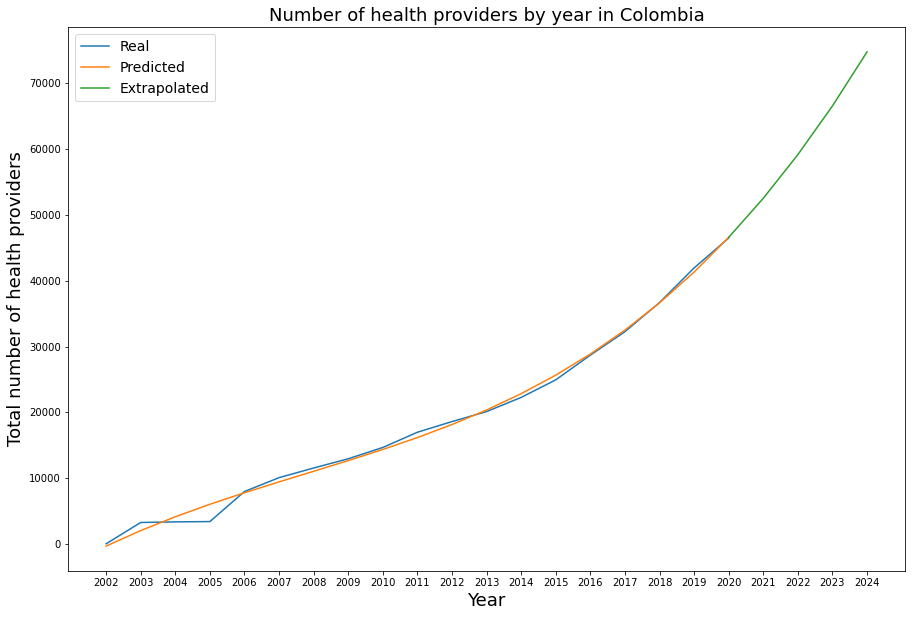

In [53]:
# Plot
fig= plt.figure(figsize=(15,10))
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_train.flatten())
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_pred.flatten())
sns.lineplot(x=YEAR_TEST, y=y_future.flatten())
plt.legend(('Real', 'Predicted', 'Extrapolated'),fontsize=14)
plt.ylabel('Total number of health providers', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Number of health providers by year in Colombia', fontsize=18)
plt.savefig(f"../images/Number_of_health_providers_by_year_in_Colombia_Poly_reg.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

# 3. EDA `sivigila`

In [54]:
sivigila

,DEPARTAMENTO,ENFERMEDAD,FECHA,EDAD,SEXO,AÑO
0,Norte de Santander,CHAGAS,2017-08-01,46,M,2017
1,Boyacá,CHAGAS,2017-05-01,87,F,2017
2,Tolima,CHAGAS,2017-09-01,58,F,2017
3,Santander,CHAGAS,2017-08-01,68,F,2017
4,Cundinamarca,CHAGAS,2017-10-01,70,F,2017
...,...,...,...,...,...,...
141004,Valle del cauca,ZIKA,2018-08-01,35,M,2018
141005,Valle del cauca,ZIKA,2018-07-01,36,M,2018
141006,Valle del cauca,ZIKA,2018-09-01,51,M,2018
141007,Valle del cauca,ZIKA,2018-05-01,38,F,2018


In [55]:
sivigila=sivigila.assign(PERIODO=sivigila.FECHA.dt.to_period('M').astype(str))

In [56]:
sivigila

,DEPARTAMENTO,ENFERMEDAD,FECHA,EDAD,SEXO,AÑO,PERIODO
0,Norte de Santander,CHAGAS,2017-08-01,46,M,2017,2017-08
1,Boyacá,CHAGAS,2017-05-01,87,F,2017,2017-05
2,Tolima,CHAGAS,2017-09-01,58,F,2017,2017-09
3,Santander,CHAGAS,2017-08-01,68,F,2017,2017-08
4,Cundinamarca,CHAGAS,2017-10-01,70,F,2017,2017-10
...,...,...,...,...,...,...,...
141004,Valle del cauca,ZIKA,2018-08-01,35,M,2018,2018-08
141005,Valle del cauca,ZIKA,2018-07-01,36,M,2018,2018-07
141006,Valle del cauca,ZIKA,2018-09-01,51,M,2018,2018-09
141007,Valle del cauca,ZIKA,2018-05-01,38,F,2018,2018-05


In [57]:
sivigilas_agg=sivigila.groupby(['DEPARTAMENTO','ENFERMEDAD','PERIODO'])\
    .agg(TOTAL_MES=('ENFERMEDAD','count')).reset_index()
sivigilas_agg

,DEPARTAMENTO,ENFERMEDAD,PERIODO,TOTAL_MES
0,Amazonas,CHAGAS,2017-01,0
1,Amazonas,CHAGAS,2017-02,0
2,Amazonas,CHAGAS,2017-03,0
3,Amazonas,CHAGAS,2017-04,0
4,Amazonas,CHAGAS,2017-05,0
...,...,...,...,...
4747,Vichada,ZIKA,2018-08,0
4748,Vichada,ZIKA,2018-09,0
4749,Vichada,ZIKA,2018-10,1
4750,Vichada,ZIKA,2018-11,0


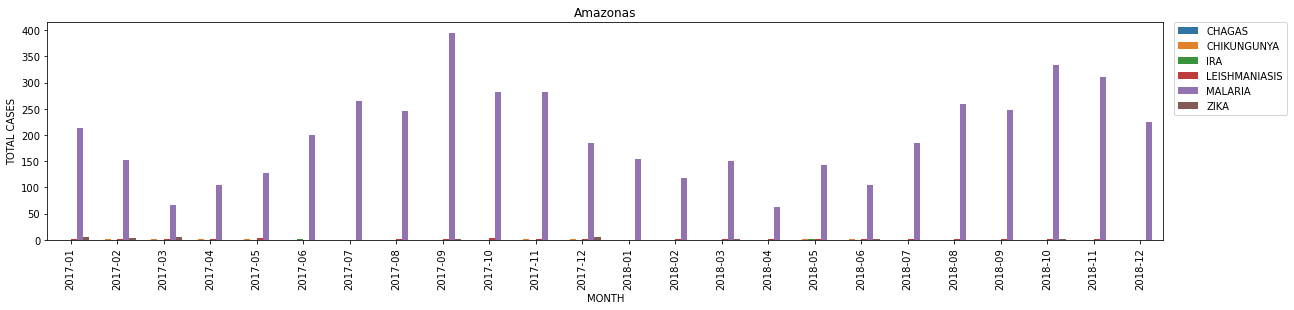

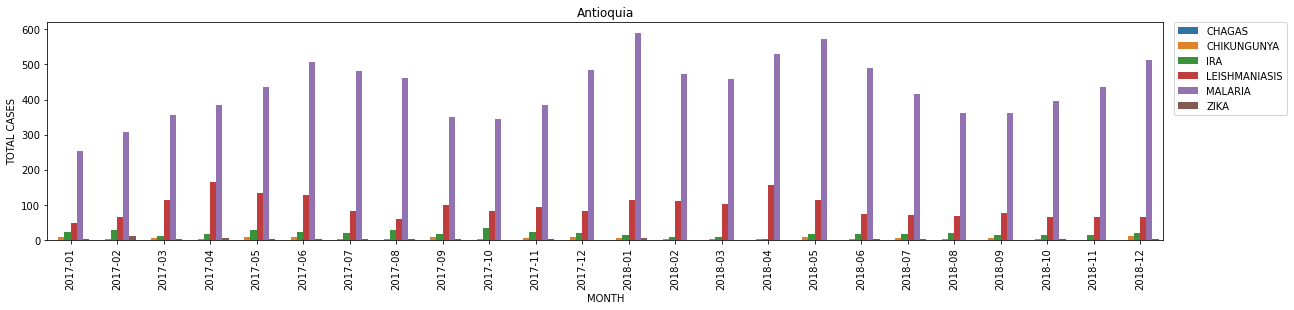

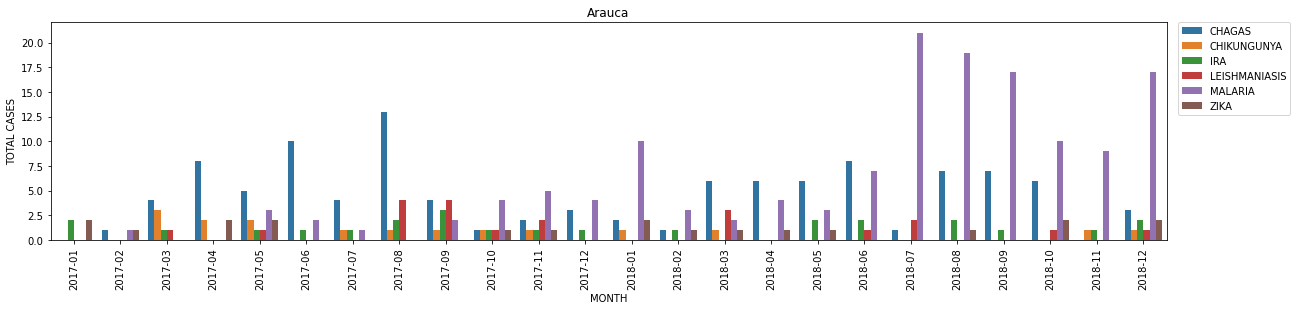

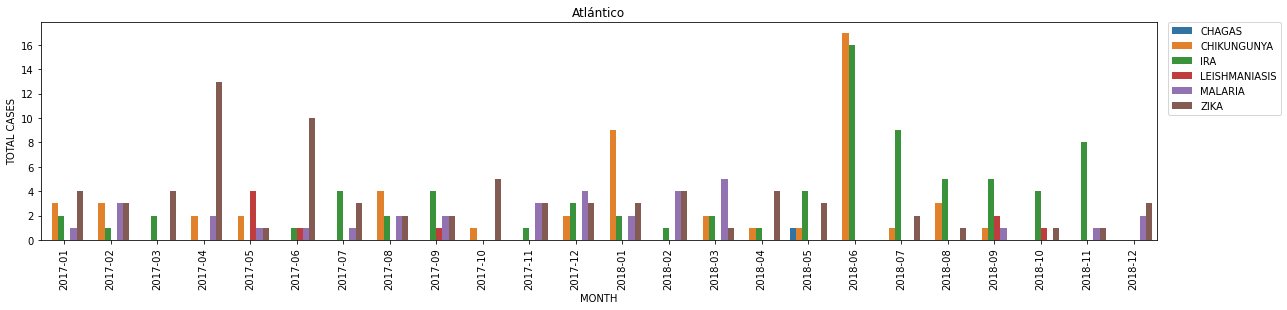

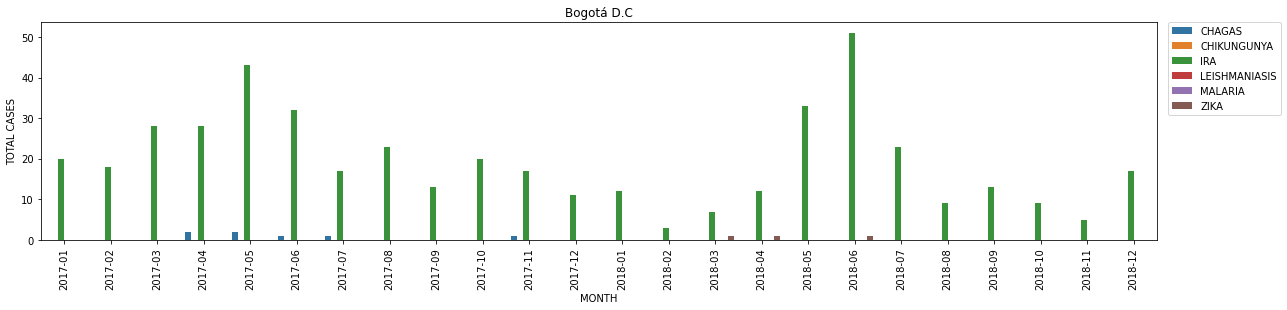

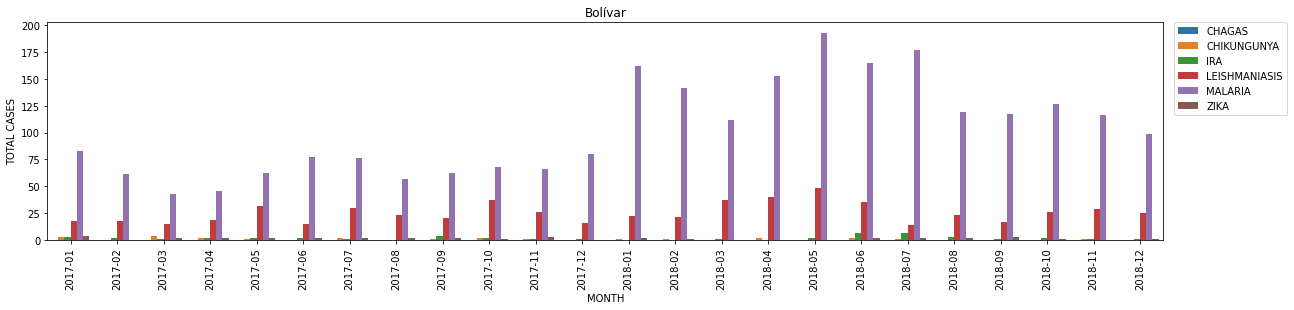

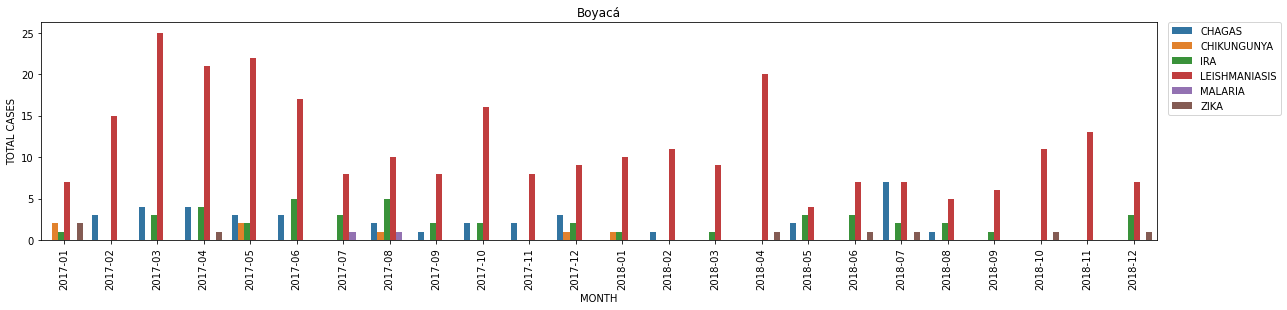

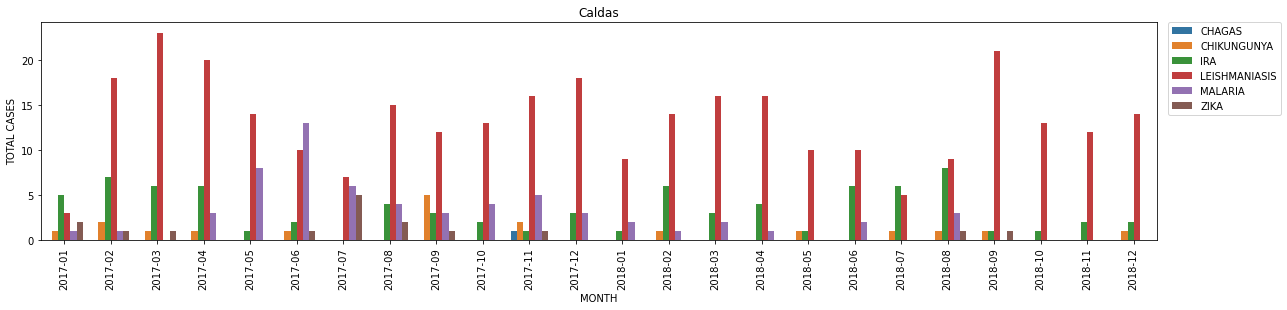

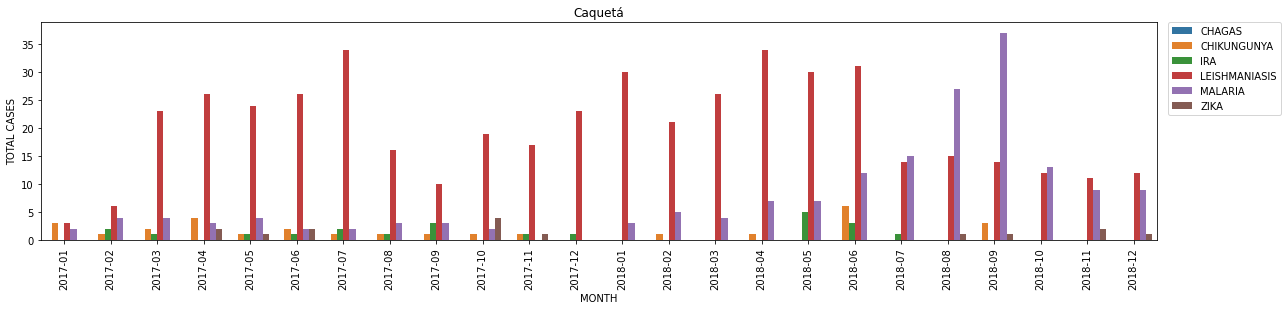

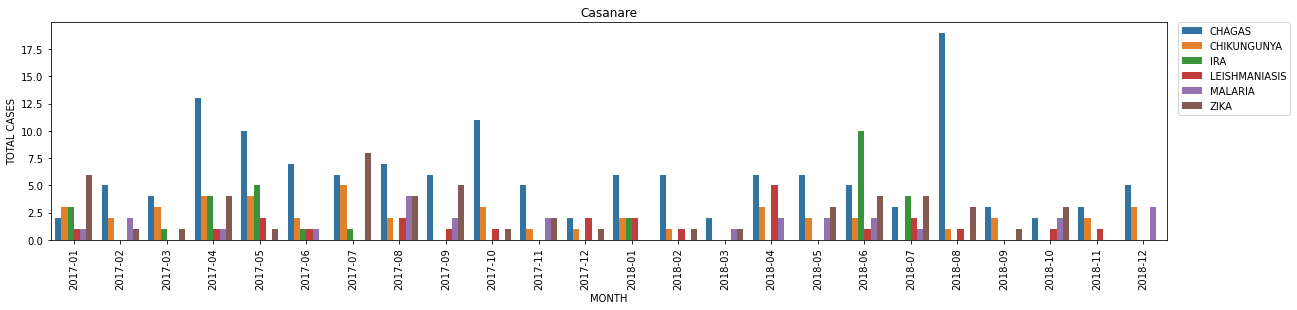

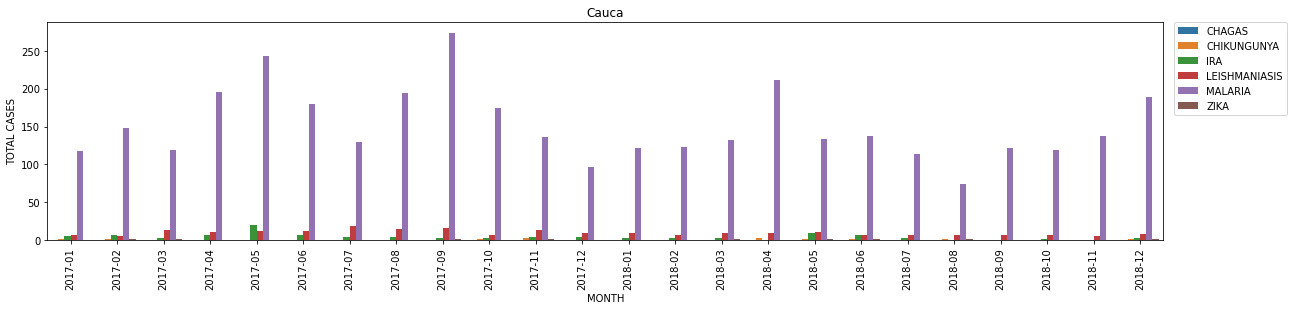

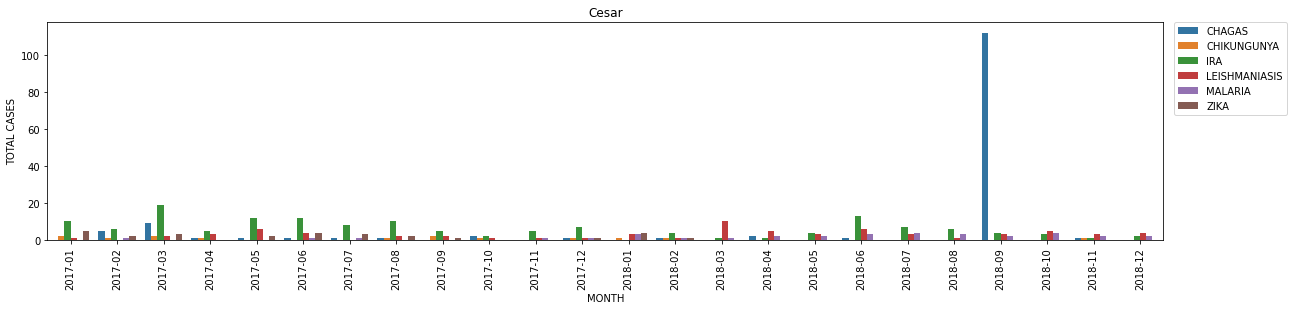

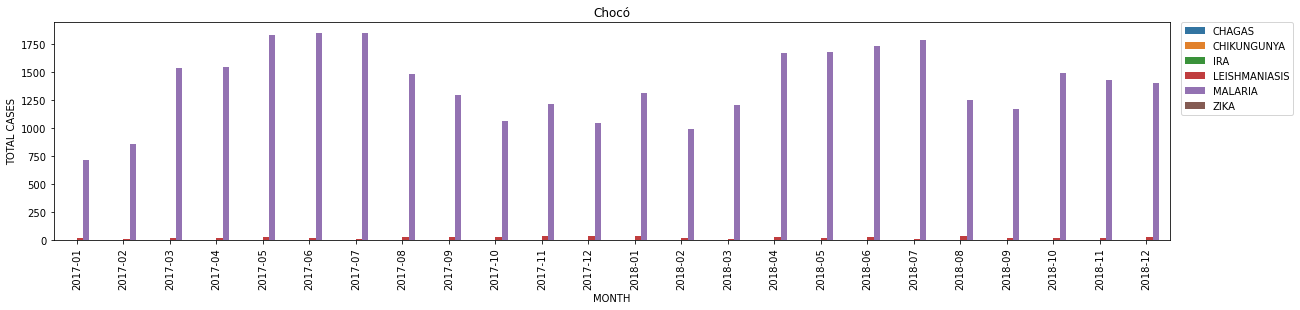

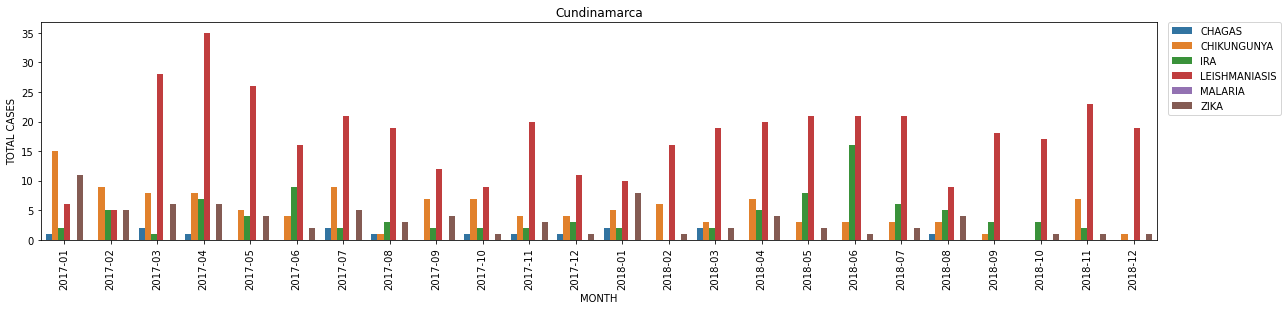

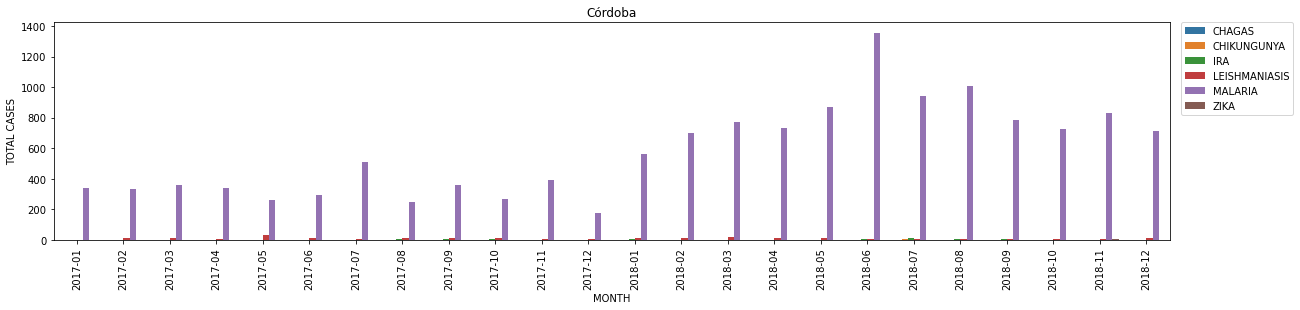

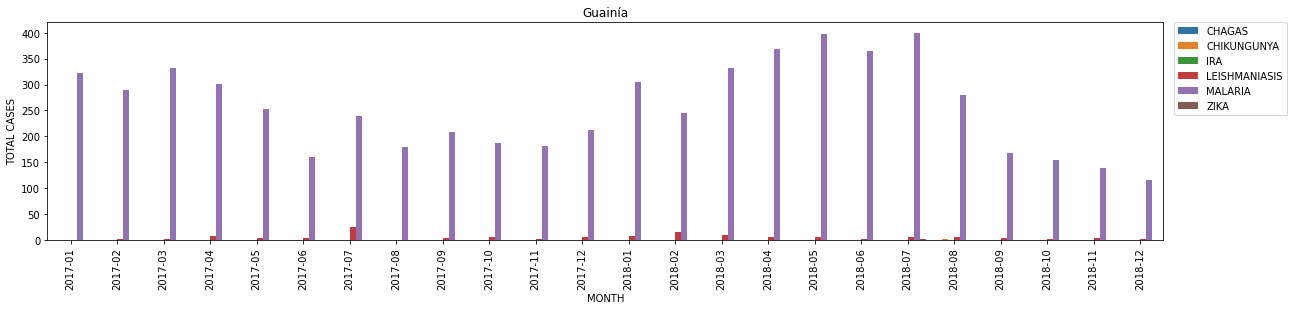

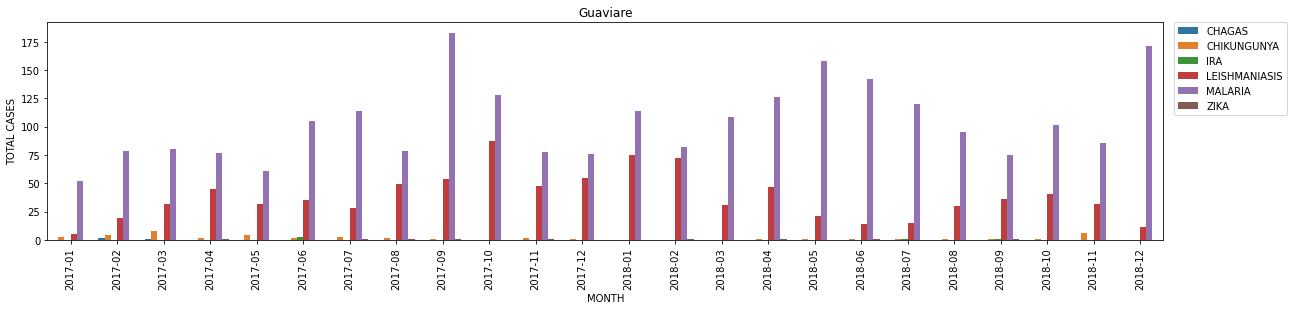

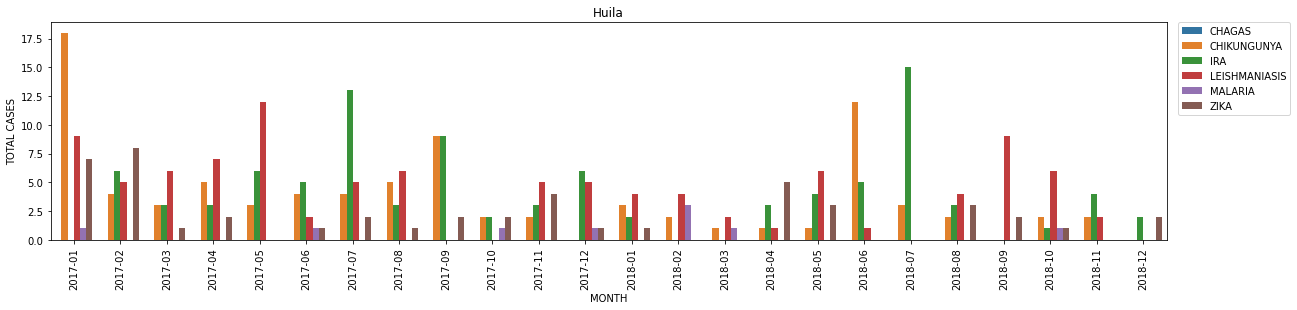

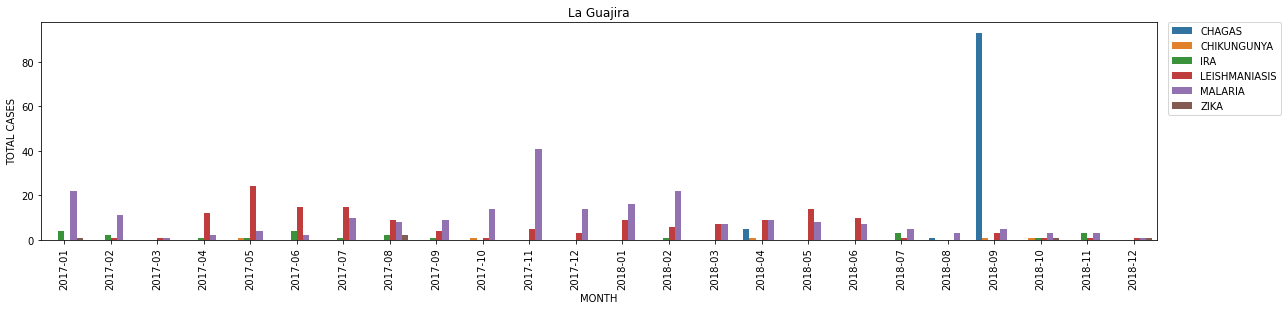

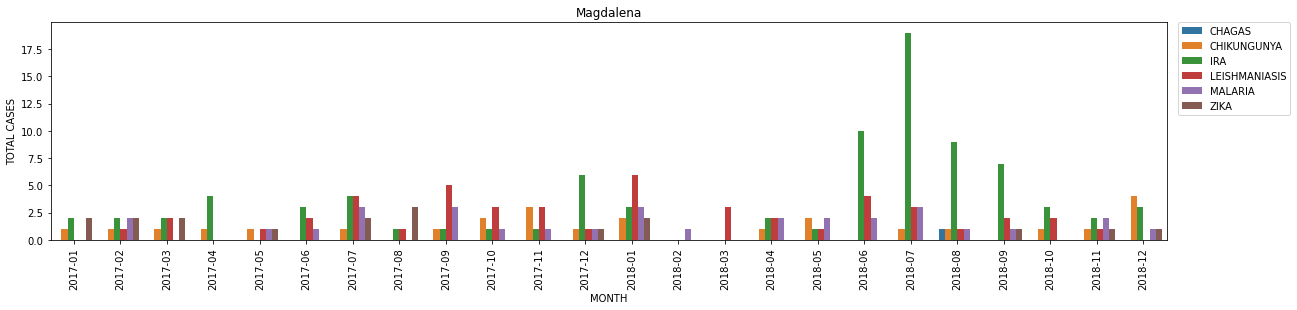

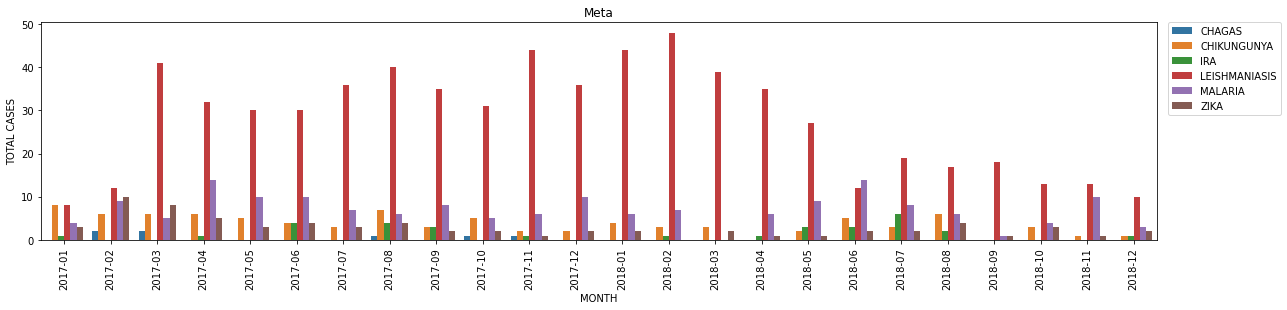

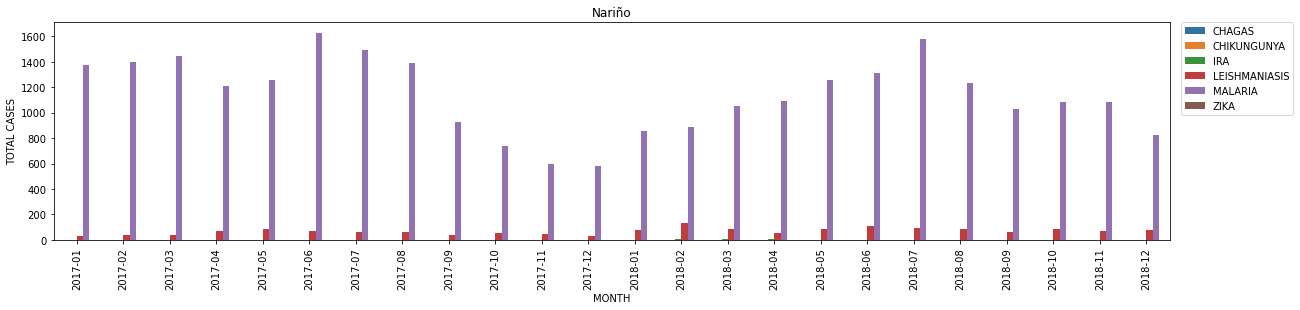

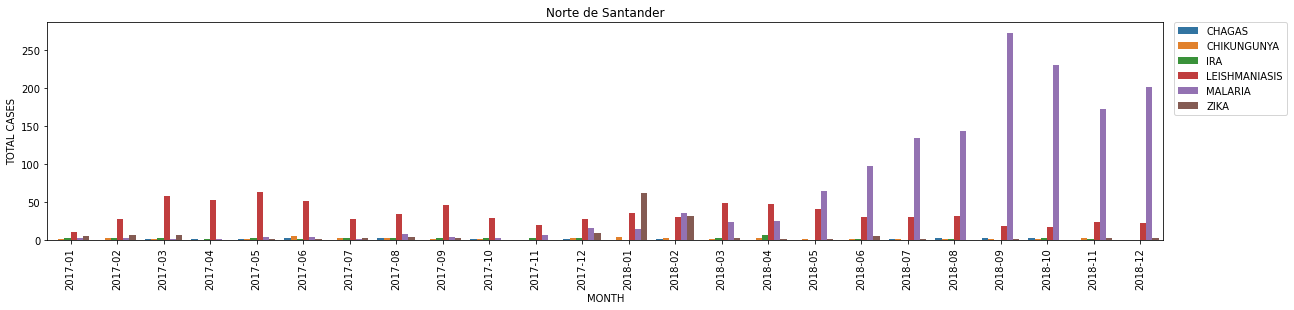

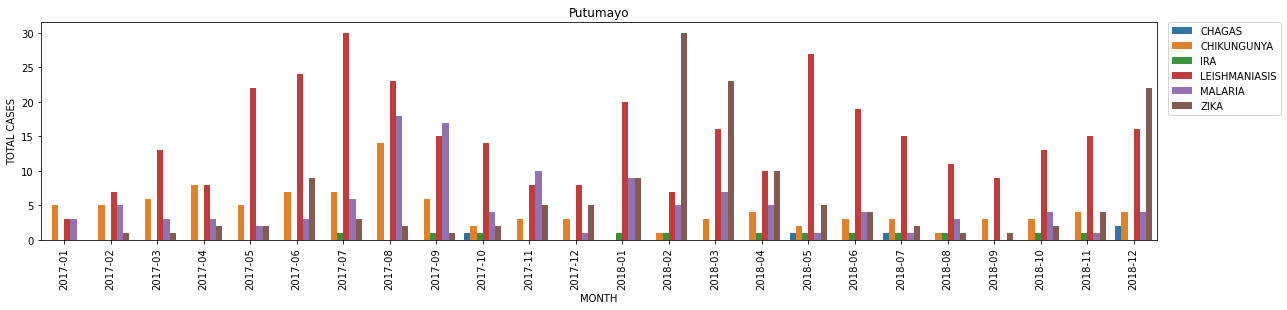

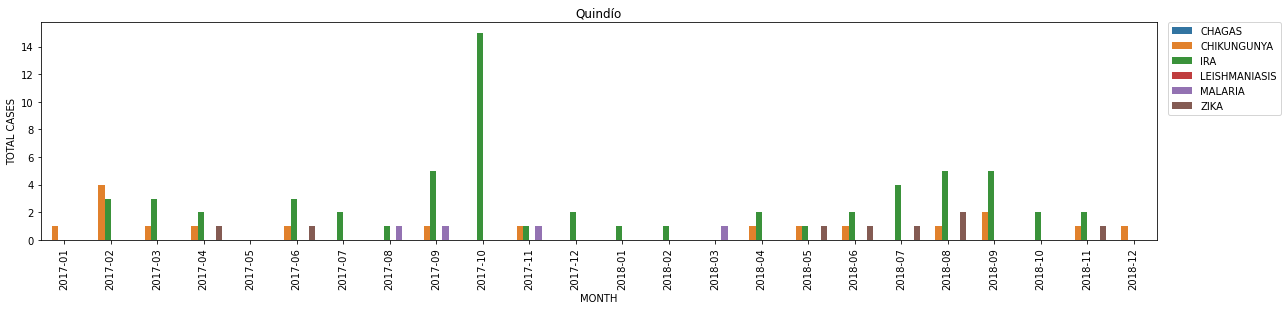

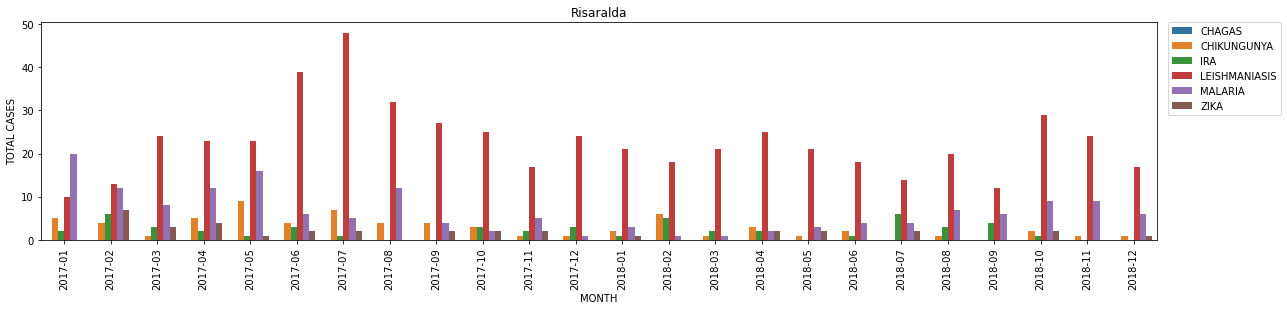

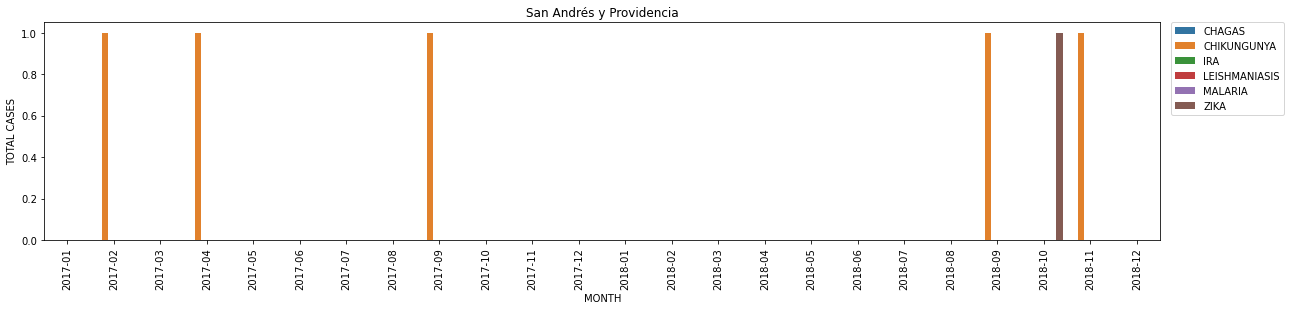

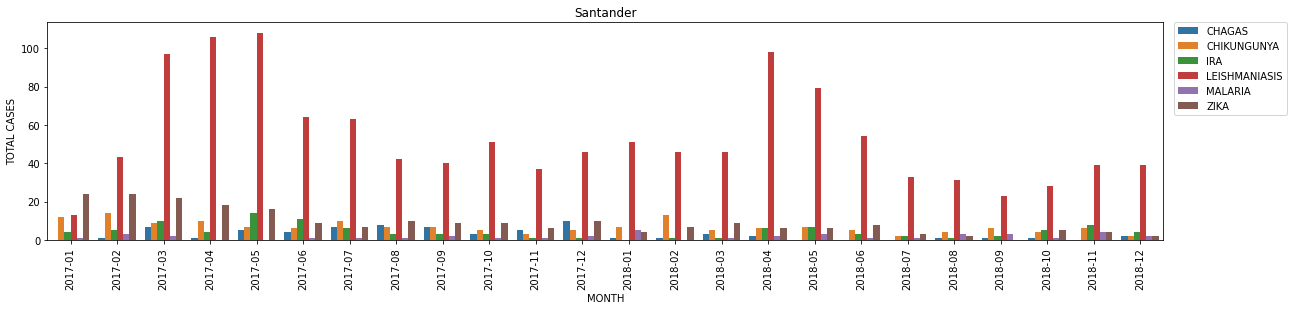

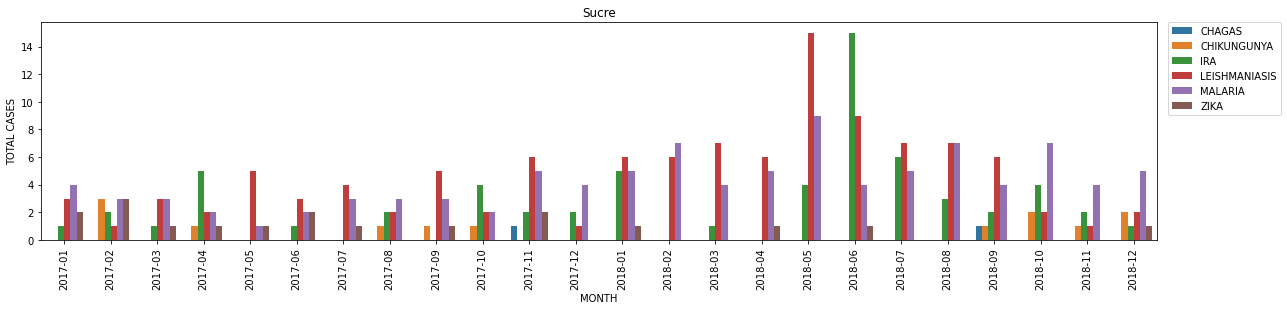

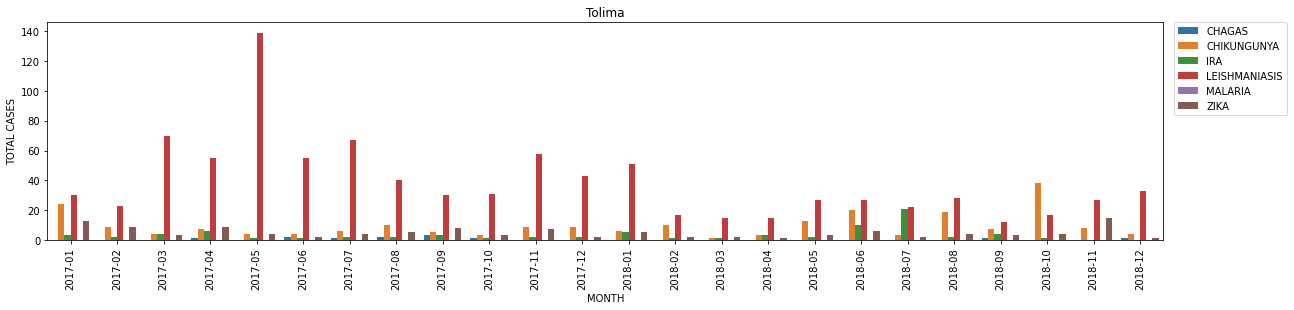

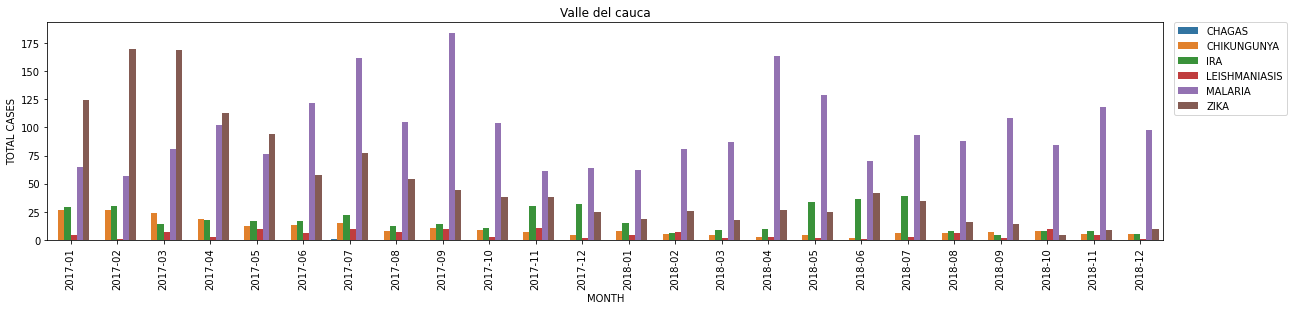

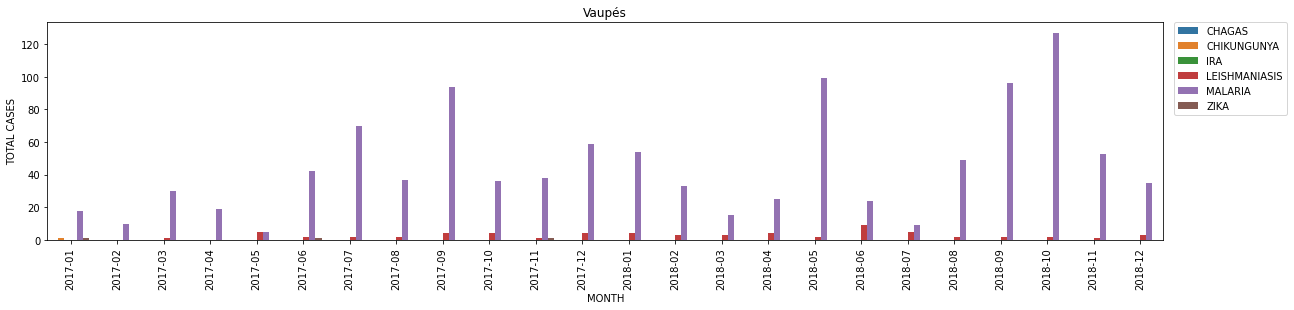

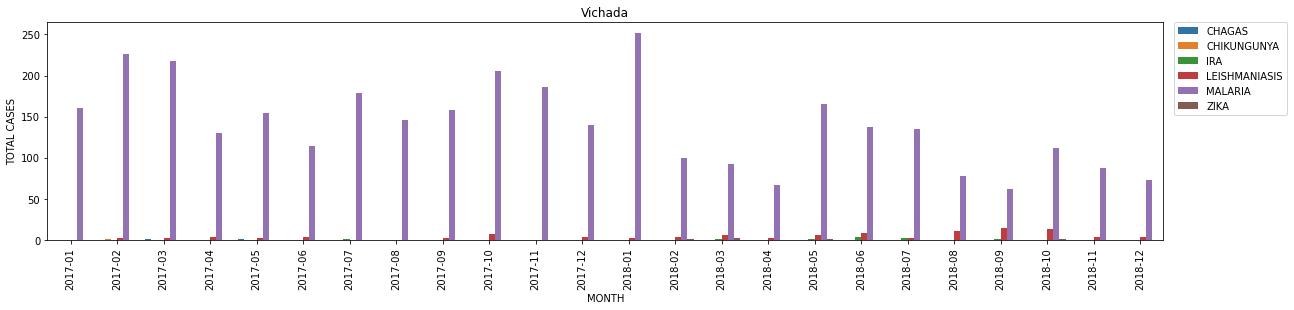

In [58]:
for i in sivigilas_agg.DEPARTAMENTO.unique():
    fig= plt.figure(figsize=(20,4))
    sns.barplot(data=sivigilas_agg[sivigilas_agg.DEPARTAMENTO==i]\
                 ,x='PERIODO', y='TOTAL_MES', hue='ENFERMEDAD')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=90)
    plt.title(i)
    plt.xlabel('MONTH')
    plt.ylabel('TOTAL CASES')
    plt.savefig(f"../images/sivigila/Diseases_{i}.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

In [59]:
sivigilas_agg_2=sivigila.groupby(['ENFERMEDAD','PERIODO'])\
    .agg(TOTAL_MES=('ENFERMEDAD','count')).reset_index()
sivigilas_agg_2

,ENFERMEDAD,PERIODO,TOTAL_MES
0,CHAGAS,2017-01,3
1,CHAGAS,2017-02,19
2,CHAGAS,2017-03,36
3,CHAGAS,2017-04,32
4,CHAGAS,2017-05,30
...,...,...,...
139,ZIKA,2018-08,49
140,ZIKA,2018-09,32
141,ZIKA,2018-10,38
142,ZIKA,2018-11,46


In [60]:
sivigilas_agg_2.PERIODO=sivigilas_agg_2.PERIODO.astype(str)

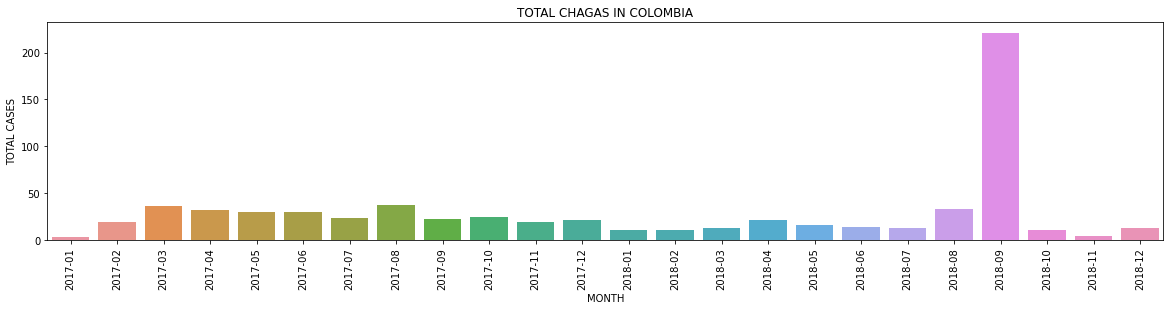

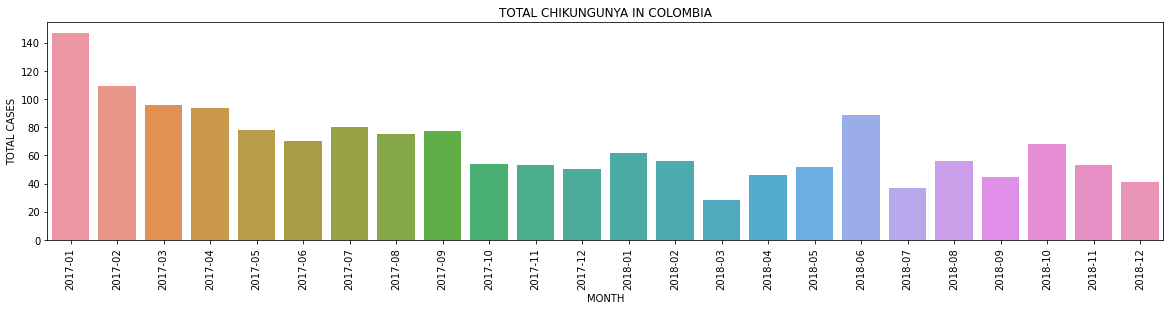

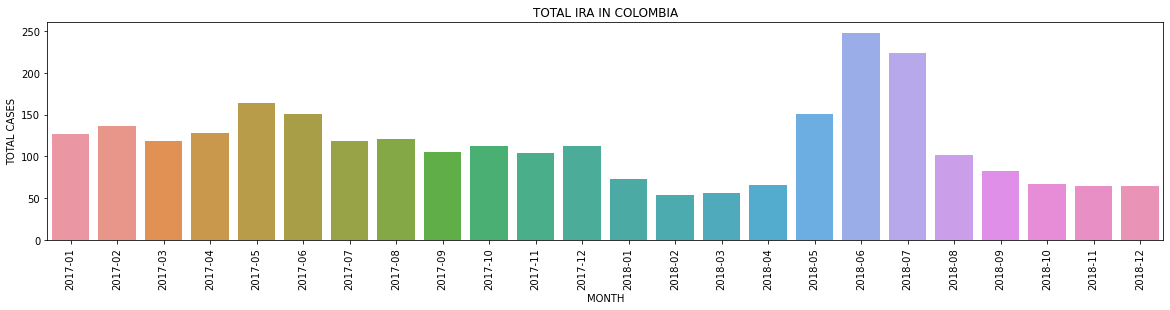

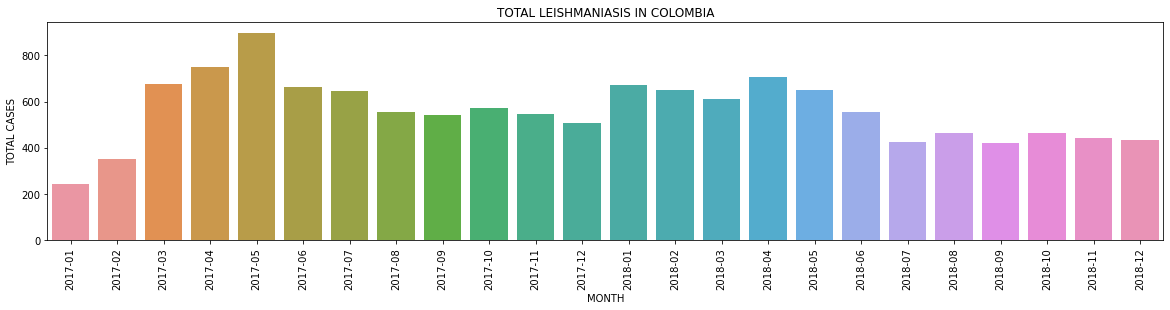

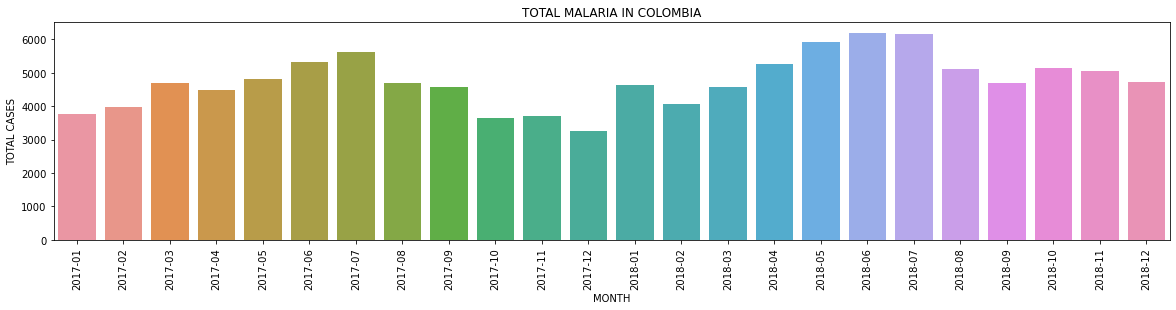

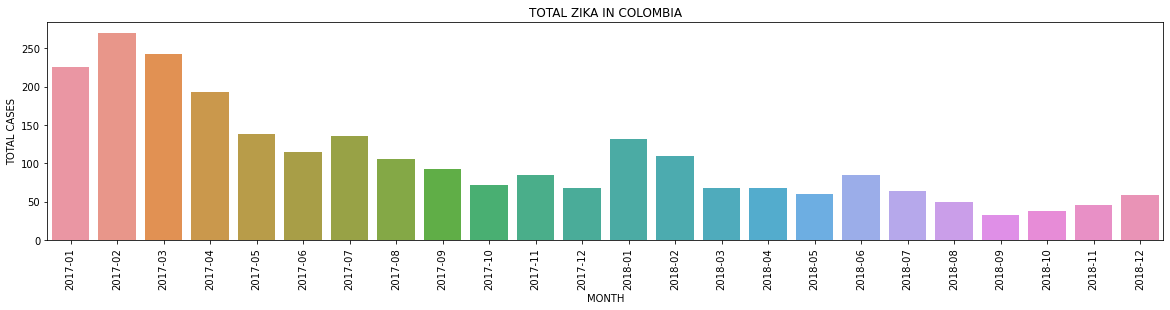

In [61]:
for i in sivigilas_agg_2.ENFERMEDAD.unique():
    fig= plt.figure(figsize=(20,4))
    sns.barplot(data=sivigilas_agg_2[sivigilas_agg_2.ENFERMEDAD==i]\
                 ,x='PERIODO', y='TOTAL_MES')
    plt.xticks(rotation=90)
    plt.xlabel('MONTH')
    plt.ylabel('TOTAL CASES')
    plt.title(f'TOTAL {i} IN COLOMBIA')
    plt.savefig(f"../images/sivigila/{i}_IN_COLOMBIA.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

# 4. EDA `nofetal`

In [62]:
nofetal

,DEPARTAMENTO,CAUSA,FECHA,GRUPO_EDAD,SEXO,AÑO
295,Casanare,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 70 a 74 años,Femenino,2017
829,Valle del cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 80 a 84 años,Femenino,2017
1113,Boyacá,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 60 a 64 años,Masculino,2017
1961,Valle del cauca,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 45 a 49 años,Masculino,2017
2406,Caquetá,Ciertas enfermedades transmitidas por vectores...,2017-01-01,De 40 a 44 años,Femenino,2017
...,...,...,...,...,...,...
462962,Sucre,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Masculino,2018
463521,Norte de Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 60 a 64 años,Masculino,2018
464086,Cesar,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 5 a 9 años,Femenino,2018
464113,Santander,Ciertas enfermedades transmitidas por vectores...,2018-12-01,De 70 a 74 años,Masculino,2018


In [63]:
nofetal.CAUSA.unique()

array(['Ciertas enfermedades transmitidas por vectores y rabia', 'IRA'],
      dtype=object)

In [64]:
nofetal_2=nofetal.assign(PERIODO=nofetal.FECHA.dt.to_period('M').astype(str))

In [65]:
nofetal_2_agg=nofetal_2.groupby(['DEPARTAMENTO','CAUSA','PERIODO'])\
    .agg(TOTAL_MES=('CAUSA','count')).reset_index()
nofetal_2_agg

,DEPARTAMENTO,CAUSA,PERIODO,TOTAL_MES
0,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017-01,1
1,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017-02,0
2,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017-03,0
3,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017-04,1
4,Amazonas,Ciertas enfermedades transmitidas por vectores...,2017-05,0
...,...,...,...,...
1531,Vichada,IRA,2018-08,1
1532,Vichada,IRA,2018-09,0
1533,Vichada,IRA,2018-10,2
1534,Vichada,IRA,2018-11,0


In [66]:
nofetal_2_agg.CAUSA=nofetal_2_agg.CAUSA.replace('IRA','LRTI').replace('Ciertas enfermedades transmitidas por vectores y rabia', 'VECTORS')

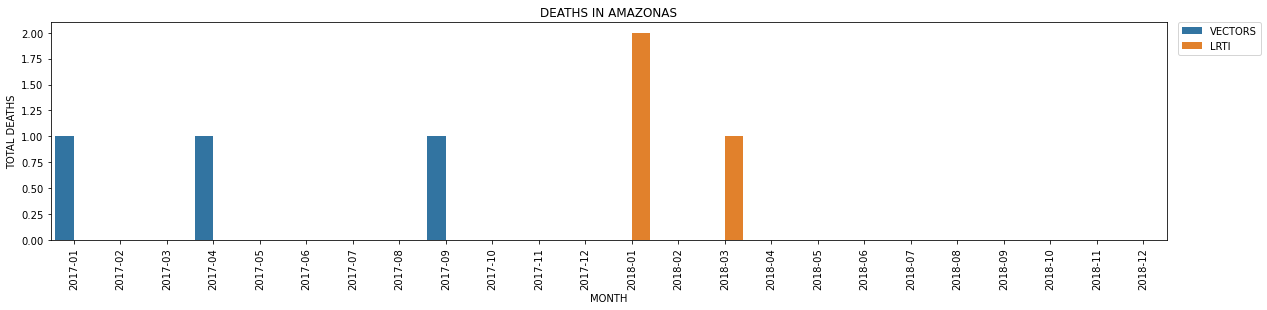

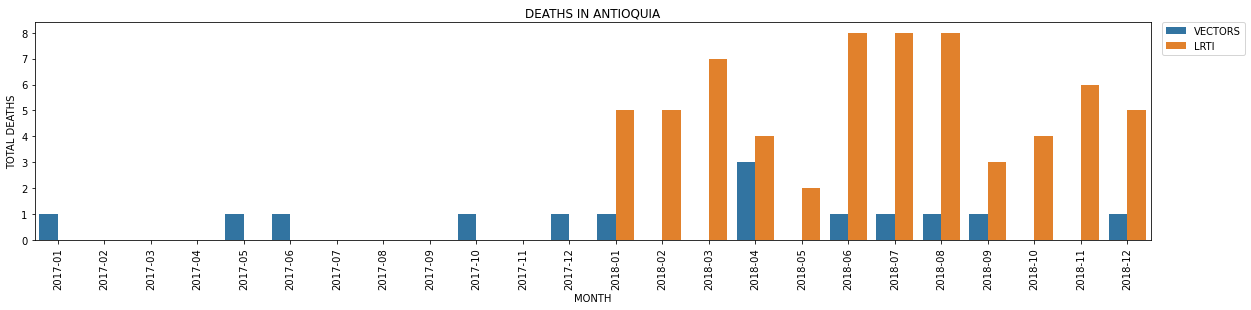

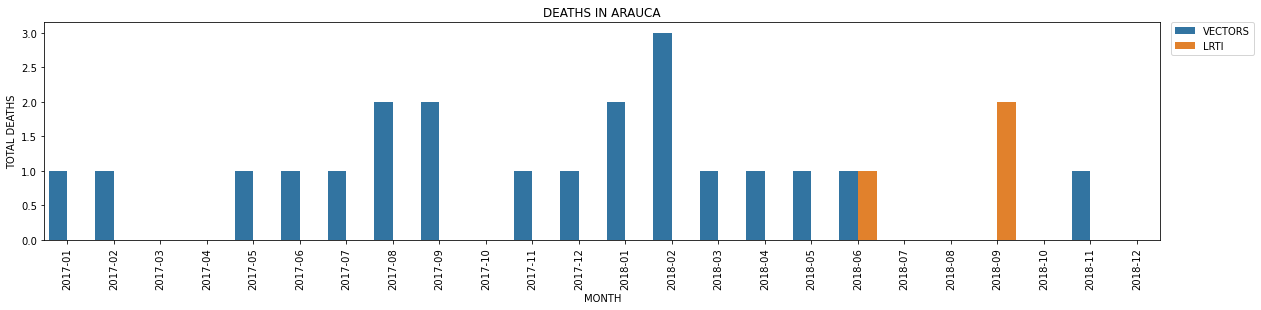

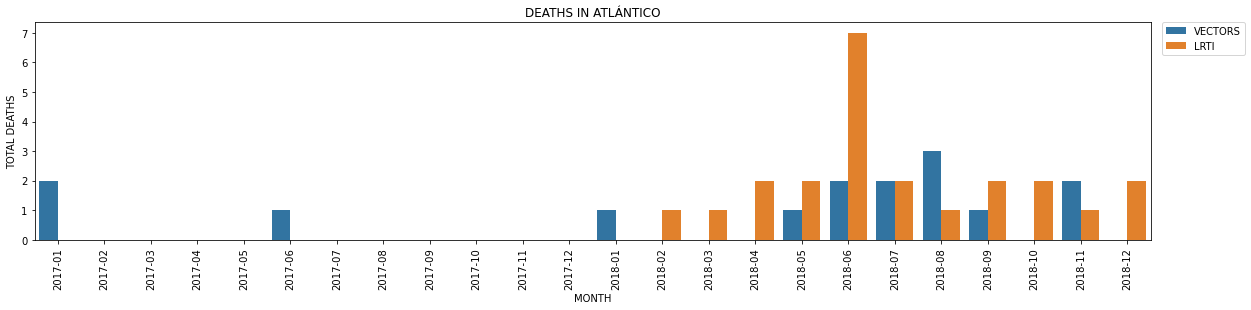

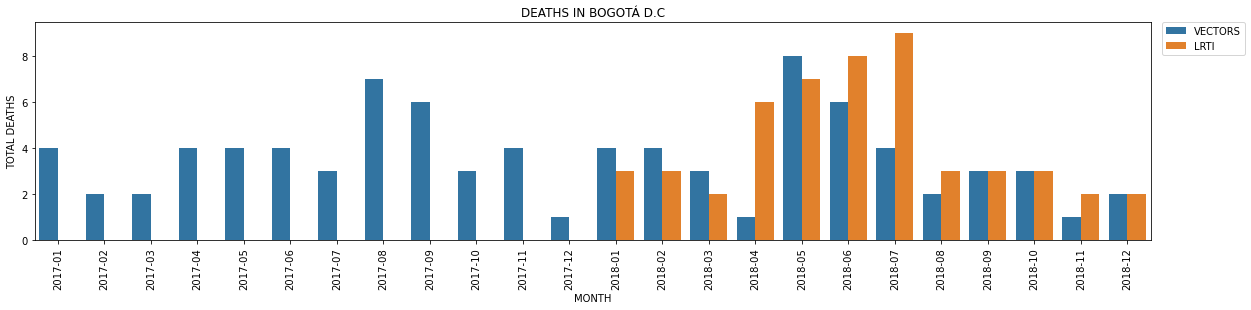

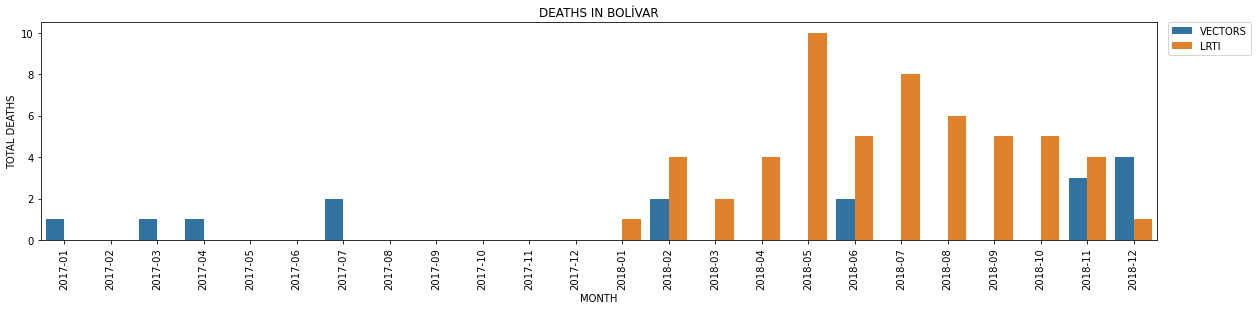

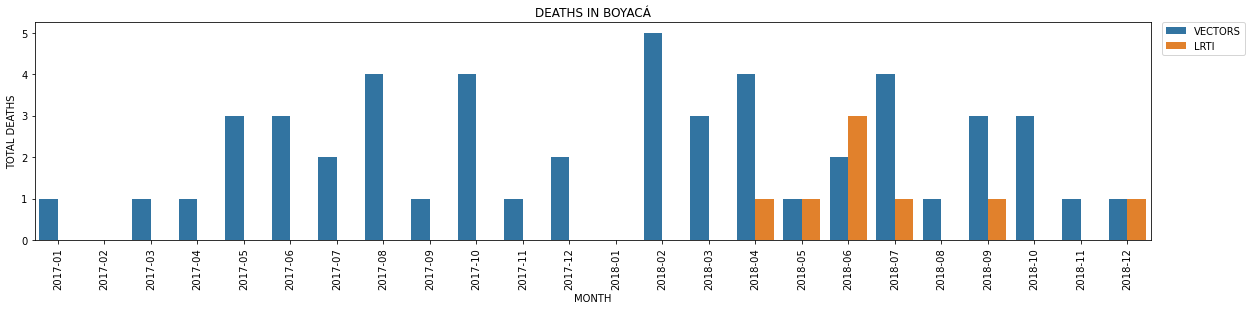

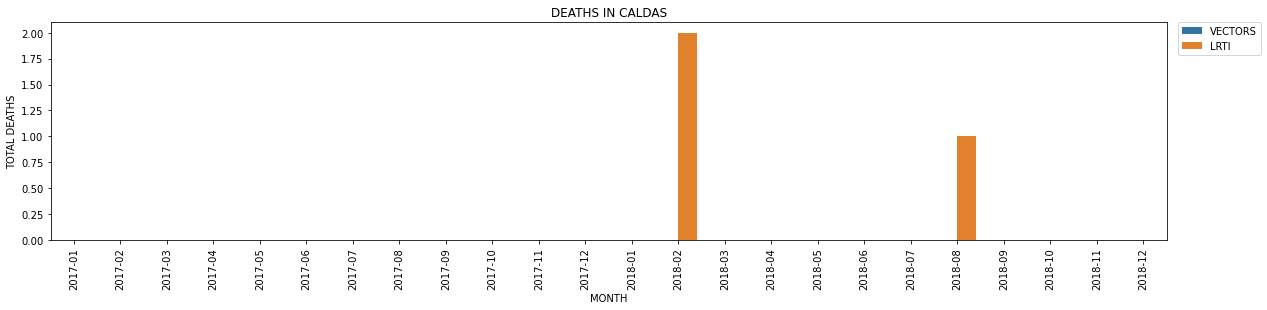

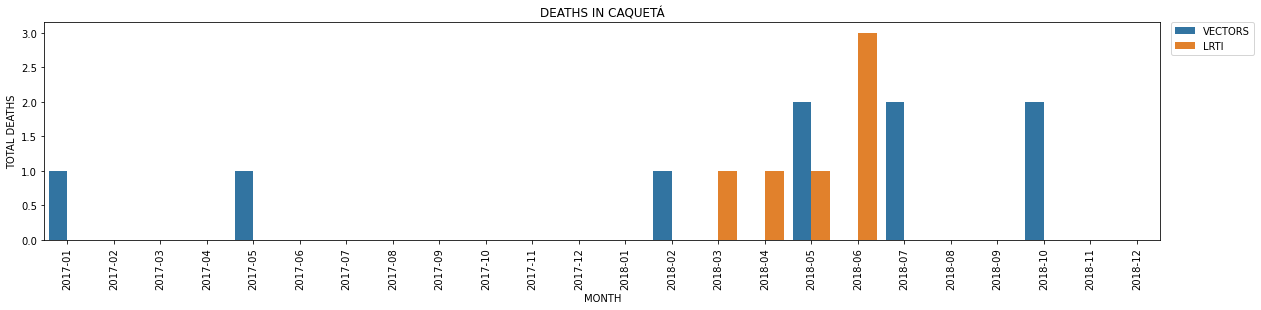

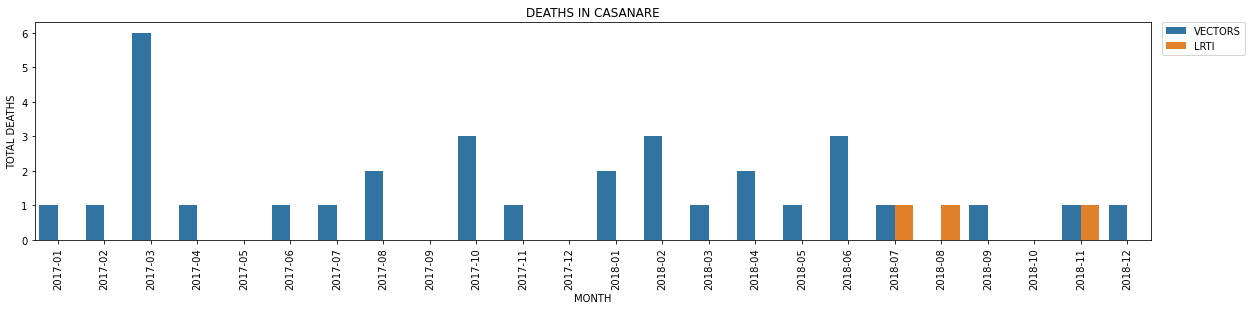

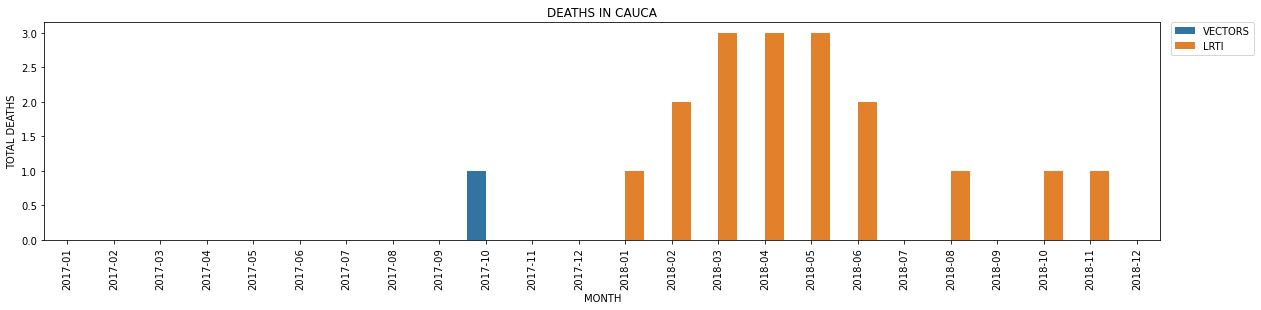

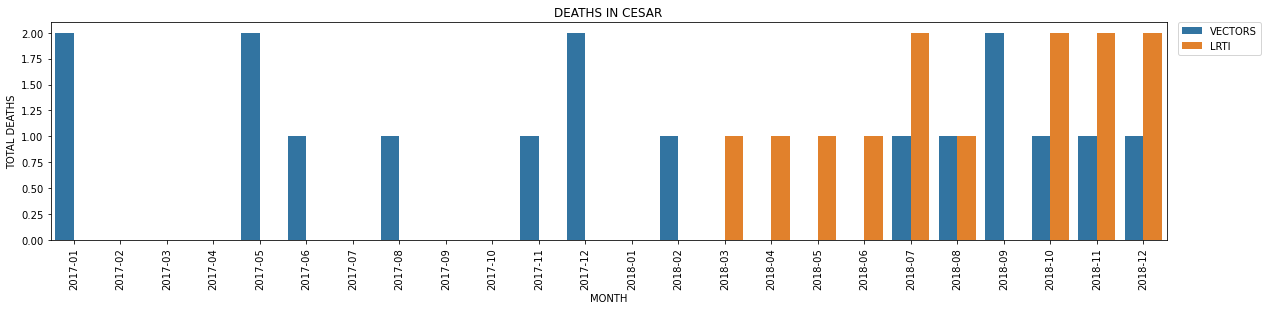

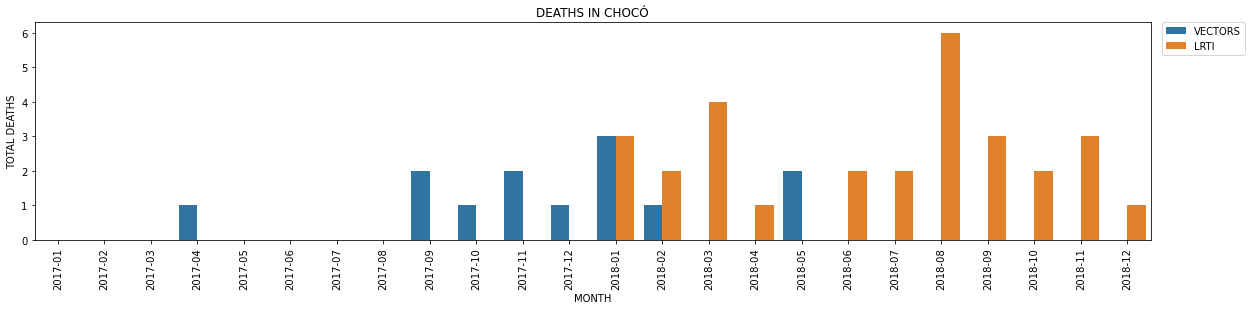

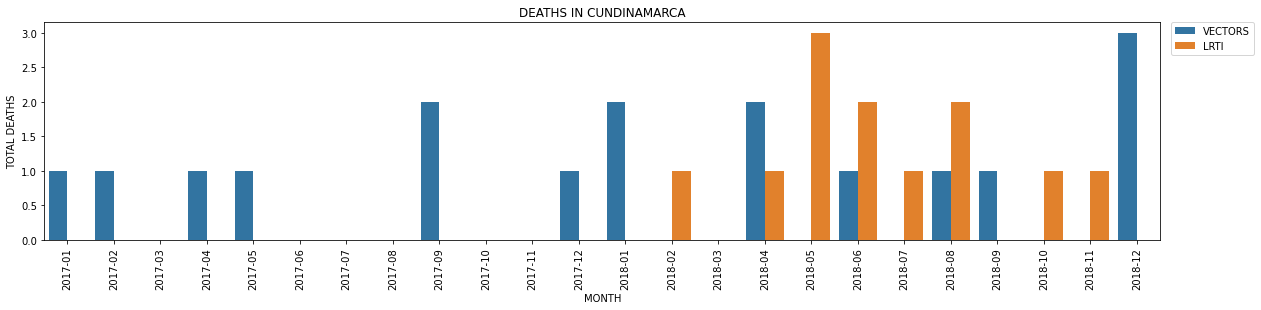

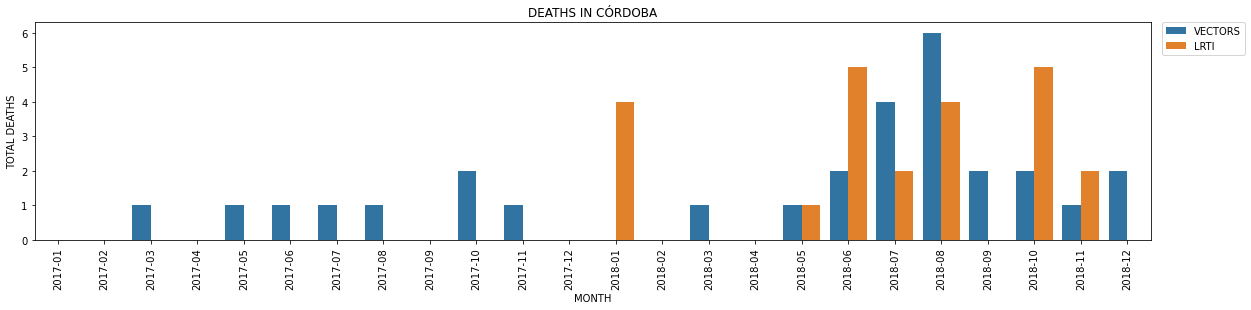

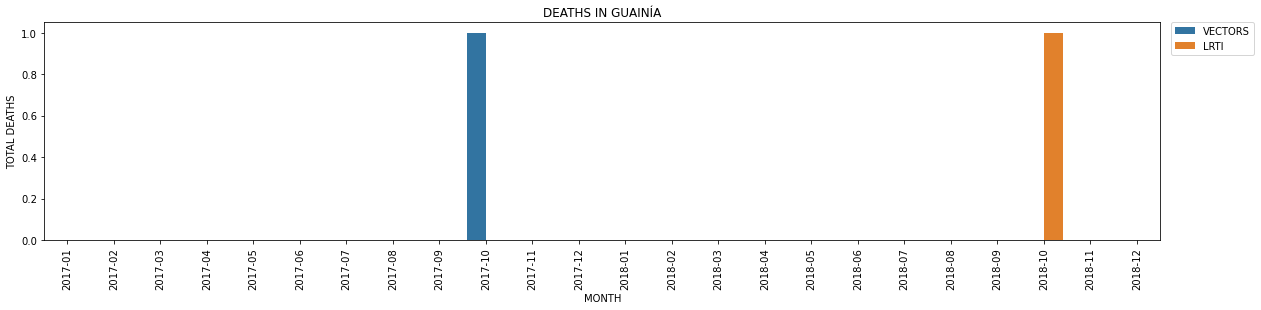

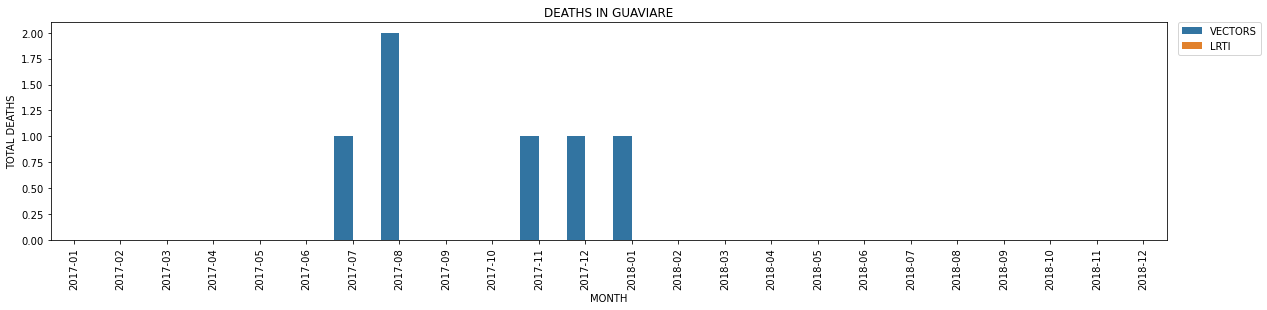

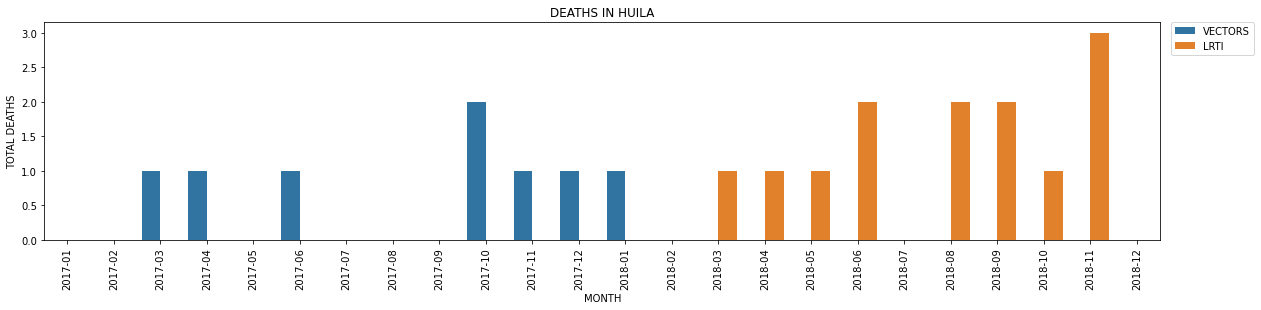

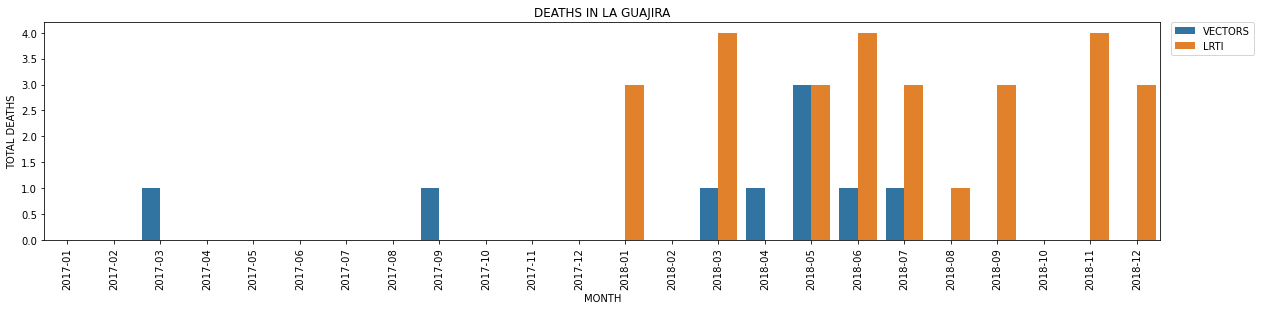

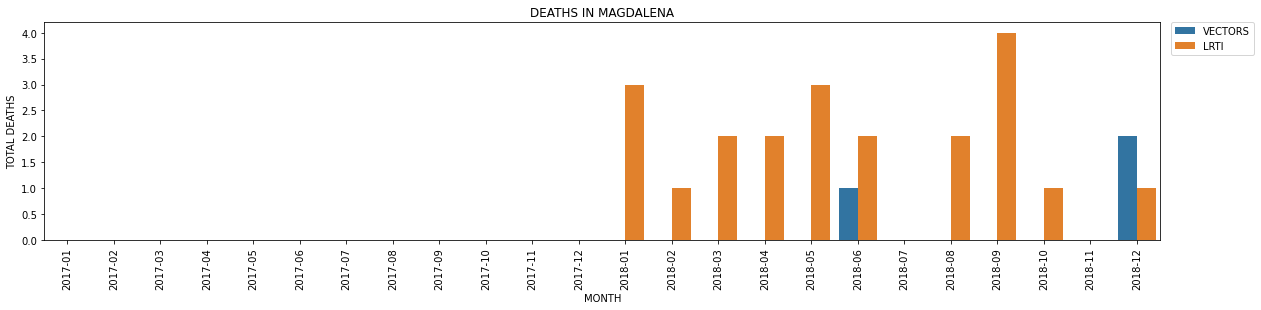

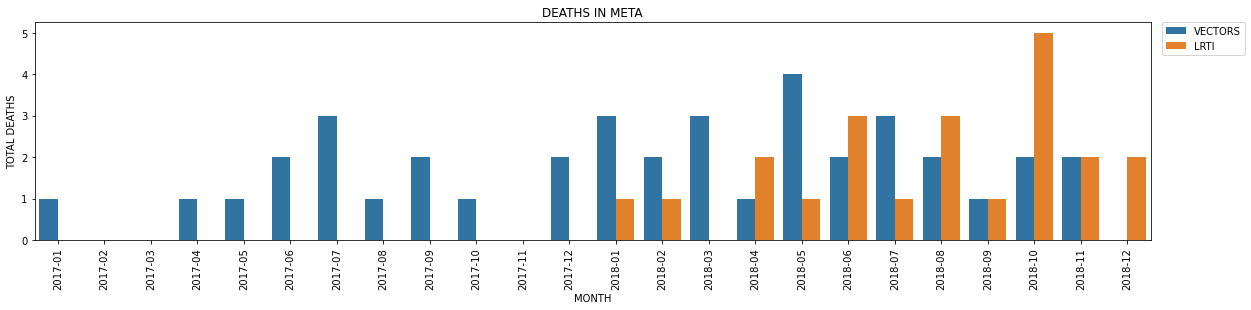

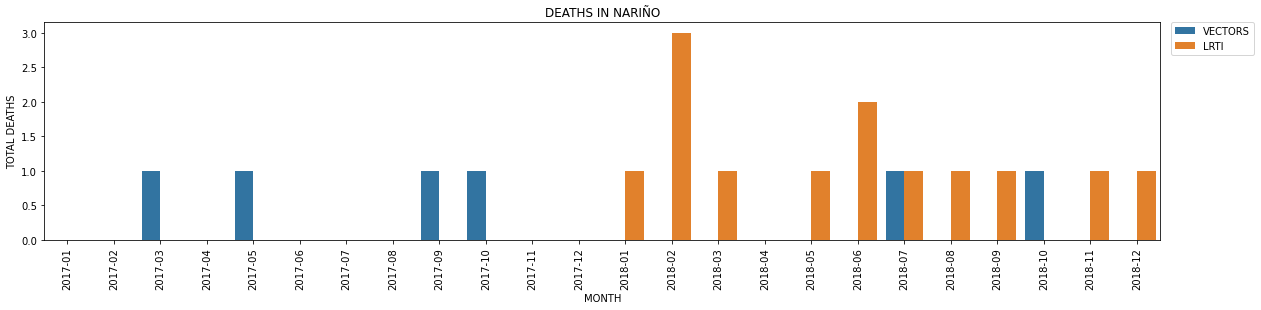

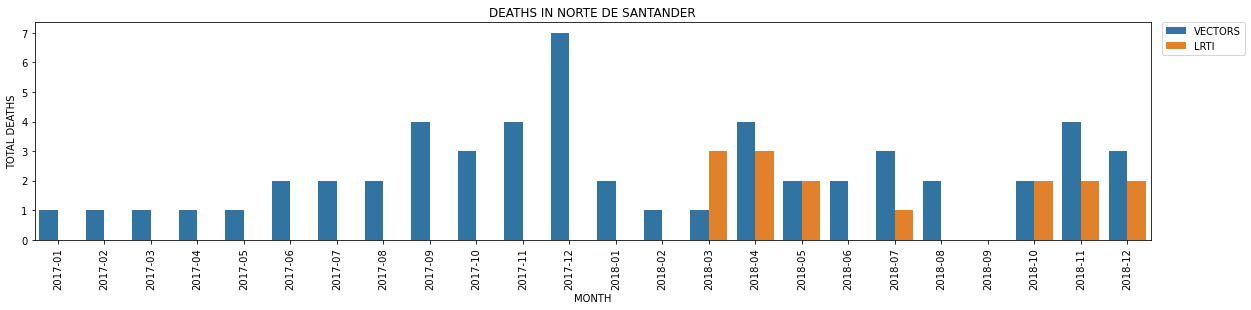

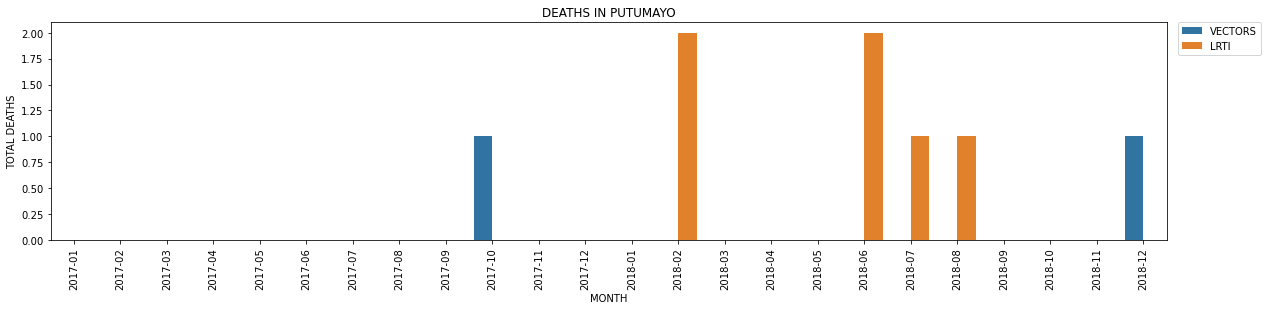

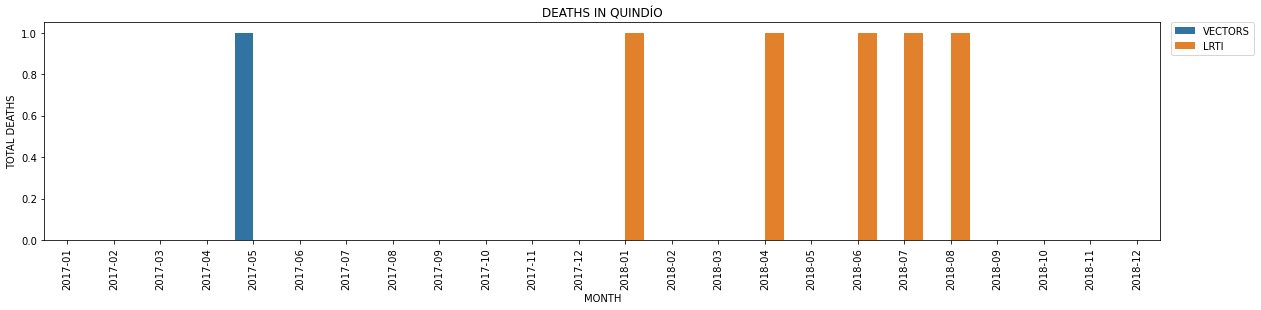

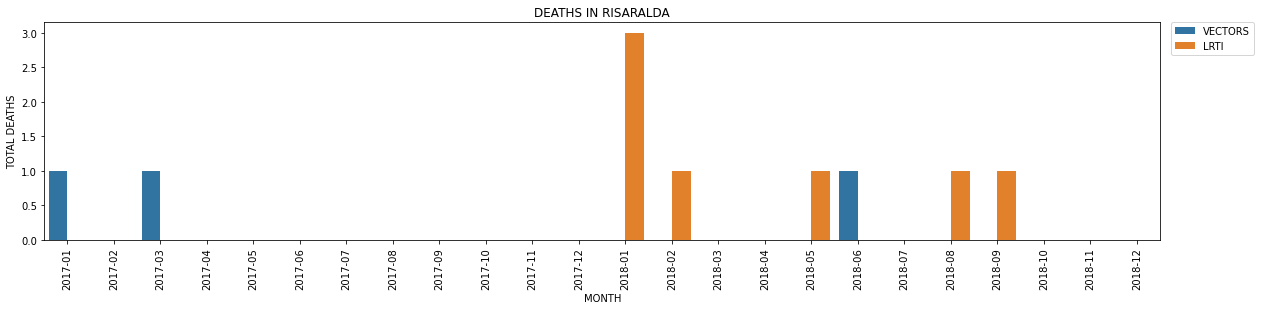

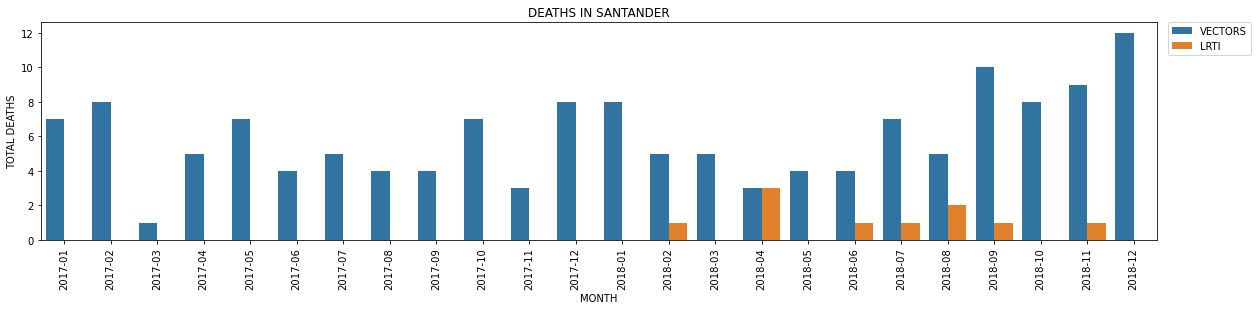

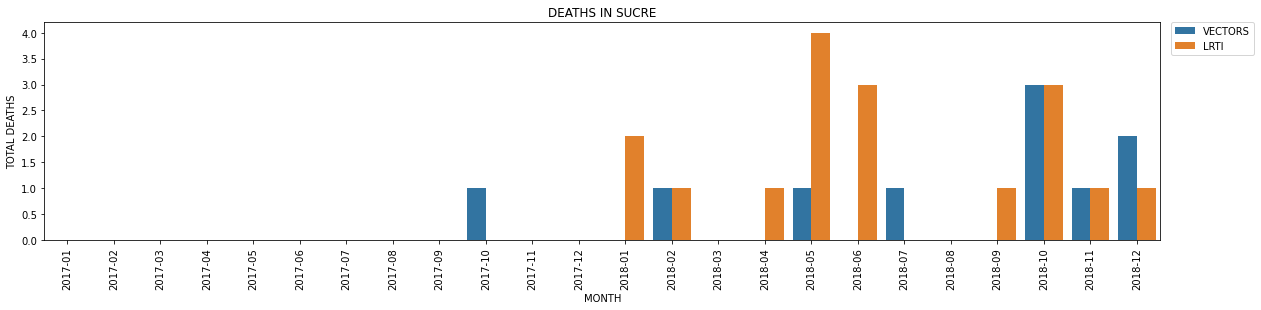

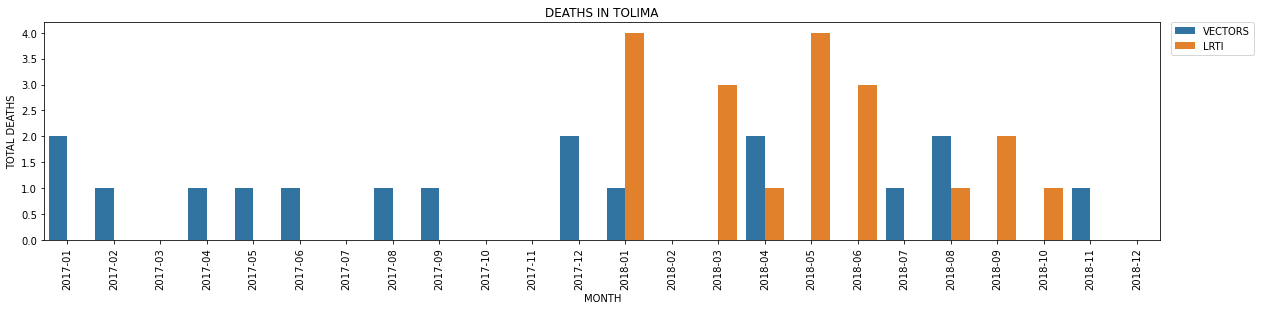

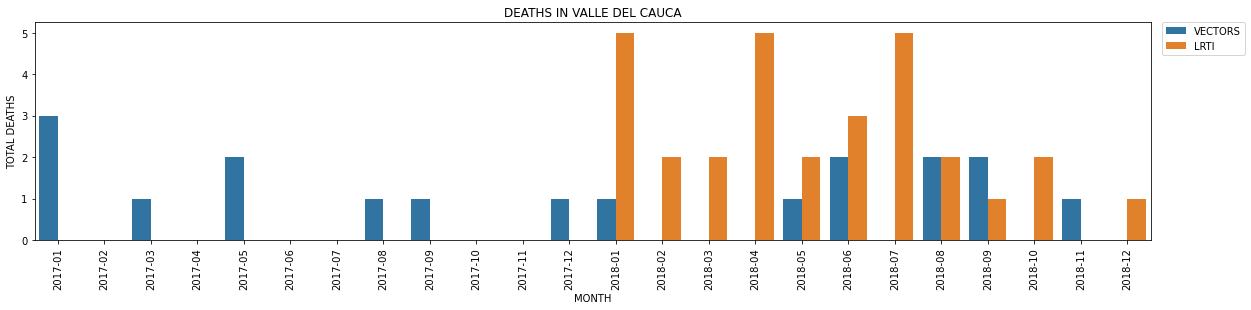

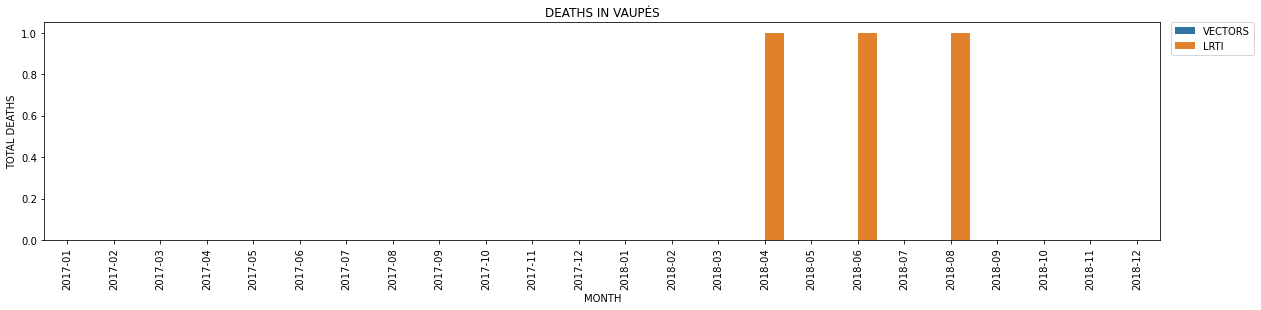

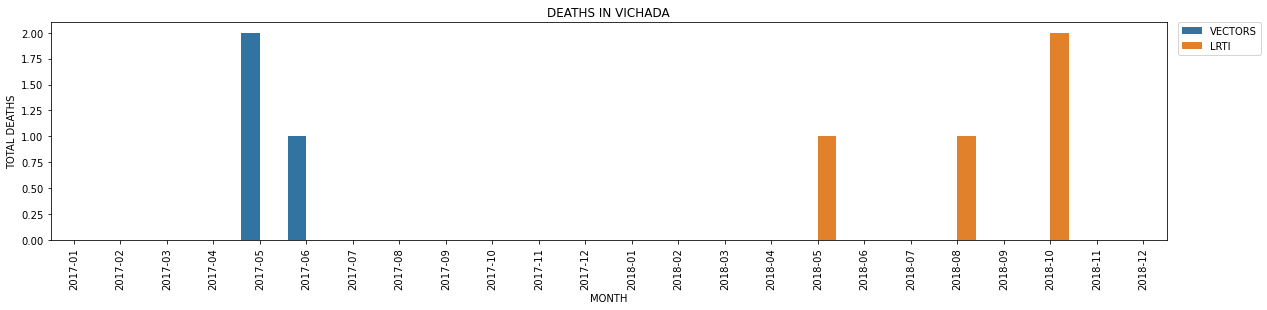

In [67]:
for i in nofetal_2_agg.DEPARTAMENTO.unique():
    fig= plt.figure(figsize=(20,4))
    sns.barplot(data=nofetal_2_agg[nofetal_2_agg.DEPARTAMENTO==i]\
                 ,x='PERIODO', y='TOTAL_MES', hue='CAUSA')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=90)
    plt.xlabel('MONTH')
    plt.ylabel('TOTAL DEATHS')
    plt.title(f'DEATHS IN {i.upper()}');
    plt.savefig(f"../images/nofetal/DEATHS_IN_{i.upper()}.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

In [68]:
nofetal_2_agg_2=nofetal_2.groupby(['CAUSA','PERIODO'])\
    .agg(TOTAL_MES=('CAUSA','count')).reset_index()
nofetal_2_agg_2

,CAUSA,PERIODO,TOTAL_MES
0,Ciertas enfermedades transmitidas por vectores...,2017-01,31
1,Ciertas enfermedades transmitidas por vectores...,2017-02,15
2,Ciertas enfermedades transmitidas por vectores...,2017-03,18
3,Ciertas enfermedades transmitidas por vectores...,2017-04,19
4,Ciertas enfermedades transmitidas por vectores...,2017-05,30
...,...,...,...
31,IRA,2018-08,53
32,IRA,2018-09,36
33,IRA,2018-10,43
34,IRA,2018-11,37


In [69]:
nofetal_2_agg_2.CAUSA=nofetal_2_agg_2.CAUSA.replace('IRA','LRTI').replace('Ciertas enfermedades transmitidas por vectores y rabia', 'VECTORS')

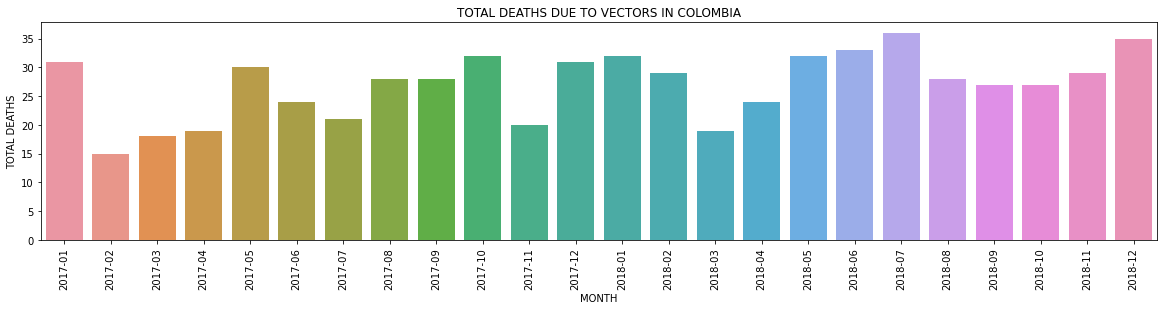

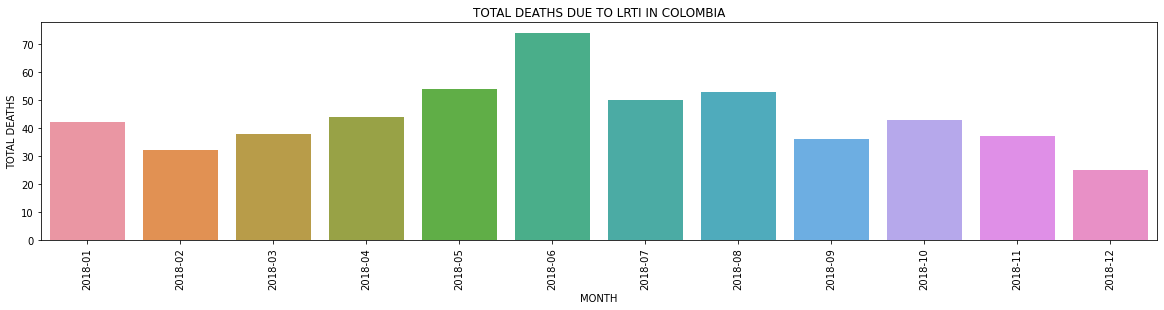

In [70]:
for i in nofetal_2_agg_2.CAUSA.unique():
    fig= plt.figure(figsize=(20,4))
    sns.barplot(data=nofetal_2_agg_2[nofetal_2_agg_2.CAUSA==i]\
                 ,x='PERIODO', y='TOTAL_MES')
    plt.xticks(rotation=90)
    plt.title(f'TOTAL DEATHS DUE TO {i.upper()} IN COLOMBIA');
    plt.xlabel('MONTH')
    plt.ylabel('TOTAL DEATHS')
    plt.savefig(f"../images/nofetal/DEATHS_DUE_TO_{i}.jpg", dpi=150, bbox_inches='tight', pad_inches=0.3);

# 5. Merge Data

In [71]:
data_merge

,DEPARTAMENTO,AÑO,TOTAL_MED,TOTAL_IPS,TOTAL_ENFERMEDADES,TOTAL_MUERTES_VECTORES,TOTAL_MUERTES_IRA,TOTAL_POBLACION
0,Amazonas,2017,6,110,2569,3,0,148052
1,Amazonas,2018,6,115,2312,0,3,153178
2,Antioquia,2017,1328,3098,6271,5,0,12593102
3,Antioquia,2018,1674,3431,6917,9,65,12814204
4,Arauca,2017,30,257,125,11,0,509643
...,...,...,...,...,...,...,...,...
59,Valle del cauca,2018,907,3231,1716,9,30,8951772
60,Vaupés,2017,0,28,487,0,0,78505
61,Vaupés,2018,0,30,659,0,3,81594
62,Vichada,2017,2,56,2047,3,0,209068


In [72]:
data_merge=data_merge.assign(MED_1M = lambda x: (x.TOTAL_MED*1000000)/(x.TOTAL_POBLACION))
data_merge=data_merge.assign(IPS_1M = lambda x: (x.TOTAL_IPS*1000000)/(x.TOTAL_POBLACION))
data_merge=data_merge.assign(ENFERMEDADES_1M = lambda x: (x.TOTAL_ENFERMEDADES*1000000)/(x.TOTAL_POBLACION))
data_merge=data_merge.assign(MUERTES_VECTORES_1M = lambda x: (x.TOTAL_MUERTES_VECTORES*1000000)/(x.TOTAL_POBLACION))
data_merge=data_merge.assign(MUERTES_IRA_1M = lambda x: (x.TOTAL_MUERTES_IRA*1000000)/(x.TOTAL_POBLACION))

data_merge[['MED_1M', 'IPS_1M', 'ENFERMEDADES_1M', 'MUERTES_VECTORES_1M','MUERTES_IRA_1M']]\
    = data_merge[['MED_1M', 'IPS_1M', 'ENFERMEDADES_1M', 'MUERTES_VECTORES_1M','MUERTES_IRA_1M']].astype('int64')

In [73]:
data_merge.columns

Index(['DEPARTAMENTO', 'AÑO', 'TOTAL_MED', 'TOTAL_IPS', 'TOTAL_ENFERMEDADES',
       'TOTAL_MUERTES_VECTORES', 'TOTAL_MUERTES_IRA', 'TOTAL_POBLACION',
       'MED_1M', 'IPS_1M', 'ENFERMEDADES_1M', 'MUERTES_VECTORES_1M',
       'MUERTES_IRA_1M'],
      dtype='object')

In [74]:
data_merge_agg=data_merge.groupby(['DEPARTAMENTO']).agg({'MED_1M':'mean','IPS_1M':'mean','ENFERMEDADES_1M':'mean','MUERTES_VECTORES_1M':'mean','MUERTES_IRA_1M':'mean'})
data_merge_agg

,MED_1M,IPS_1M,ENFERMEDADES_1M,MUERTES_VECTORES_1M,MUERTES_IRA_1M
DEPARTAMENTO,,,,,
Amazonas,39.5,746.0,16222.5,10.0,9.5
Antioquia,117.5,256.5,518.0,0.0,2.5
Arauca,61.0,535.0,321.5,20.0,2.5
Atlántico,69.0,387.5,24.5,1.0,2.0
Bogotá D.C,139.5,261.5,16.0,2.5,1.5
...,...,...,...,...,...
Sucre,92.5,683.0,85.5,2.0,4.5
Tolima,84.0,363.5,259.0,2.5,3.5
Valle del cauca,93.5,346.0,248.0,1.0,1.5


In [75]:
data_merge_agg=data_merge_agg.drop(columns='MED_1M')

In [76]:
heat_labels=[
                'IPS',
                'Diseases',
                'Deaths due to vectors',
                'Deaths due to LRTI',
            ]

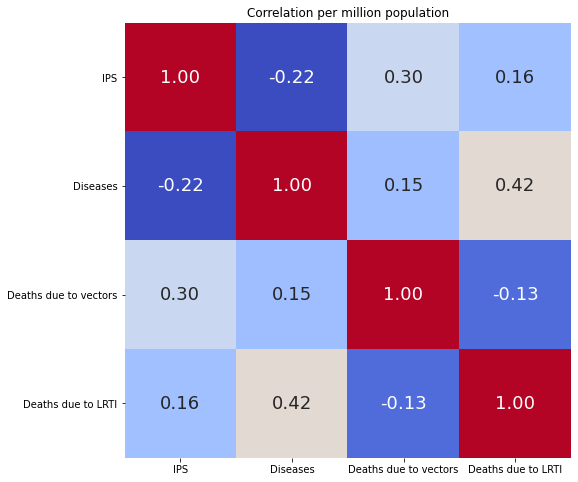

In [77]:
plt.figure(figsize=(8,8))
sns.heatmap(data_merge_agg.corr(), cbar = False, annot= True, fmt= '.2f',annot_kws={'size': 18}, cmap= 'coolwarm',
           xticklabels= heat_labels, 
           yticklabels= heat_labels,)
plt.title('Correlation per million population')
plt.savefig('../images/Correlation per million population.jpg', dpi=150, bbox_inches='tight', pad_inches=0.3)   
plt.xticks(rotation=0);

In [78]:
X=data_merge_agg.iloc[:,0:3]
y=data_merge_agg.iloc[:,3]

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=24)
data_split_list=[X_train, X_test, y_train, y_test]

In [80]:
from sklearn.metrics import r2_score, mean_squared_error

def fit_predict_measure(model, model_name, data_split_list, df_resultados):
    
    X_train, X_test, y_train, y_test=data_split_list 
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    a_subset= 'train'
    a_r2=r2_score(y_train, y_train_pred)
    a_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    a_series= pd.Series([model_name,a_subset,a_r2,a_rmse], index = df_resultados.columns)
    df_resultados=df_resultados.append(a_series, ignore_index=True)
    
    a_subset= 'test'
    a_r2=r2_score(y_test, y_test_pred)
    a_rmse=np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    a_series= pd.Series([model_name,a_subset,a_r2,a_rmse], index = df_resultados.columns)
    df_resultados=df_resultados.append(a_series, ignore_index=True)
    return df_resultados

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

lr = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=3, random_state=42)

knnr = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=3))

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
polynomial_reg = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression())

lista_modelos=[lr, dtr, knnr, polynomial_reg]
lista_nombre_modelos=['LinearRegression',
                      'DecisionTreeRegressor',
                      'KNeighborsRegressor',
                      'polynomial_reg'                      
                     ]

df_resultados = pd.DataFrame(columns=['modelo','subset','r2', 'rmse'])
for i, model in enumerate(lista_modelos):
    df_resultados=fit_predict_measure(model, lista_nombre_modelos[i], data_split_list, df_resultados)
    
df_resultados

,modelo,subset,r2,rmse
0,LinearRegression,train,0.296466,3.634028
1,LinearRegression,test,0.014200,1.585493
2,DecisionTreeRegressor,train,0.882427,1.485591
3,DecisionTreeRegressor,test,-2.012705,2.771714
4,KNeighborsRegressor,train,0.515631,3.015323
5,KNeighborsRegressor,test,-0.331155,1.842402
6,polynomial_reg,train,0.997299,0.225186
7,polynomial_reg,test,-40.026974,10.228332
